# **Age Group Classification using Multiple Touchscreen Gestures**

### Child Safety Project

Tom Birmingham & Dr. Hossain, Southern CT State University, Computer Science Department, New Haven, CT

![University Banner](<https://clubrunner.blob.core.windows.net/00000400324/EventImages/951e9035-3850-4f27-99d4-5a5d4bd17430-southern-connecticut-state-university(1).jpg>)

photo: [connecticut.csteachers.org](https://connecticut.csteachers.org/events/chapter-meeting-november-2019-southern-connecticut-state-university)


# About

This notebook represents the thesis work of graduate student Thomas Birmingham under the advisement of Dr. Hossain, Southern Connecticut State University (SCSU) Computer Science Department.

## Purpose

The purpose of the project is to further the state-of-the-art in age group classification using multiple touchscreen gestures and parallel fusion. Previous methods for classifying users (as child, teen, or adult) have been performed by other students in the project with Tap, Zoom, and Swipe gestures using machine learning. In order to further the state-of-the-art, this project will combine gestures using three types of parallel fusion to determine the most effective method for age group classification using multiple touchscreen gestures.

## Methodology

In order to determine the most effective method of parallel fusion for age classification, we must first obtain the same or better results of classification using features of each gesture Swipe, Zoom, and Tap. After classificiton of each gesture is completed, classification with parallel fusion will be performed at the feature level, score level, and decision level. The performance of each level of fusion will be assessed to determine the most effective method for age group classification.


# Prerequisites

This notebook was created on Apple M3 Max with 36 GB of memory. Not everyone has access to these computerers so this notebook can be made to run on Google Colab as well, where students can access shared compute resources with large amounts of RAM. This project has also been reviewed for memory optimization to reduce the amount of memory required to run these notebooks. For example, after loading the Child Safety Dataset, a Python object for each gesture is created as a Pandas Dataframes and exported to the /Checkpoints directory as a Python "pickle" file. Working from /Checkpoints allows users to resume their work without the time or space complexity of working with the raw dataset. You can check how much memory is available on your current runtime by running the following code block:

In [1]:
# check available memory
from psutil import virtual_memory

def print_available_memory():
    ram_gb = virtual_memory().total / 1024**3
    print('Your runtime has {:.1f} GB of available RAM\n'.format(ram_gb))
    if ram_gb < 20:
        print('This is not considered a high-RAM runtime')
    else:
        print('This is considered a high-RAM runtime')

print_available_memory()

Your runtime has 36.0 GB of available RAM

This is considered a high-RAM runtime


**Note:** Any variable **not** contained within a fuction is treated as a global variable. In the above code block, notice the variable `ram_gb` is contained within the function `print_available_memory()`. Variables that are contained within a function do not persist after the function has been called. Variables outside of functions are treated as global variables, will persist, and use available memory. While you work with this notebook, try not to use variables outside of function definitions unless they are needed. You can check variables in memory and their size in bytes using the following code block: 

In [2]:
# Standard library imports
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
initial_vars = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith(
    '_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

# Initialize total
total = 0

# Print header
print(f"{'variable':<15}{'size (bytes)':<15}")
print(f"{'--------':<15}{'------------':<15}")

# Print each variable and its size
for (var, size) in initial_vars:
    total += size
    if size > 160 and var not in ["initial_vars", "total"]:
        print(f"{var:<15}{size:<15}")

# Print total in KB or MB
if total < 1024 * 1024:
    print(f"\n{'TOTAL:':<15}{total/1024:.1f} KB")
elif total < 1024 * 1024 * 1024:
    print(f"\n{'TOTAL:':<15}{total/1024/1024:.1f} MB")
else:
    print(f"\n{'TOTAL:':<15}{total/1024/1024/1024:.1f} GB")

# Delete temporary variables
del ipython_vars, initial_vars, var, size, total

variable       size (bytes)   
--------       ------------   

TOTAL:         0.4 KB


Run this cell at any time to show what variables are used in memory and the total amount of memory used by these . Unused variables can be removed with the `del` keyword followed by the variable. Remove them after the cell where they are no longer used!

## Imports and Helper Functions
run Python Standard Library imports, Third-Party imports, and load helper functions into memory

In [3]:
# Standard library imports
import inspect
import json
import math
import os
import pickle
import sys
from glob import glob

# Third-party imports
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd
from tpot import TPOTClassifier


def load_dataframe(df_name):
    filepath = os.path.join("Checkpoints", f"{df_name}.pkl")
    if os.path.exists(filepath):
        with open(filepath, 'rb') as input:
            df = pd.read_pickle(input)
            print(f"Loaded {df_name} from {filepath}")
            return df
    else:
        print(f"File {filepath} does not exist.")
        return None


def save_dataframe(df):
    # Create the Checkpoints directory if it doesn't exist
    checkpoints_dir = 'Checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    # Get the variable name of the DataFrame dynamically
    frame = inspect.currentframe().f_back
    variable_name = None
    for name, value in frame.f_locals.items():
        if value is df:
            variable_name = name
            break

    if variable_name is None:
        raise ValueError("Could not determine the variable name of the DataFrame.")
    
    # Create the file path
    file_path = os.path.join(checkpoints_dir, f"{variable_name}.pkl")

    # Save the DataFrame as a pickle file
    with open(file_path, 'wb') as output:
        pickle.dump(df, output)
        print(f"DataFrame saved as {file_path}")
    

def get_dataset_files():
    if 'google.colab' in sys.modules:
        print("Using Google Colab hosted runtime")
        files = get_dataset_files_from_google_drive()
    else:
        print("Using local runtime")
        files = get_dataset_files_locally()
    return files


def get_dataset_files_from_google_drive():
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Create Symbolic Links to directories 'Child_Safety_Data' and 'Checkpoints'
    ! ln -s "/content/drive/MyDrive/Child Safety Project/Child_Safety_Data"
    ! ln -s "/content/drive/MyDrive/Child Safety Project/Checkpoints"

    # Get files in Child_Safety_Data and output total number of files
    files = glob(r'Child_Safety_Data/**/*.txt', recursive=True)
    print("Total Files:", len(files))
    return files


def get_dataset_files_locally():
    files = glob(r'../Dataset/Child_Safety_Data/**/*.txt', recursive=True)
    print("Total Files:", len(files))
    return files

# Data Collection
The Data Collection section loads the required data from the `Child_Safety_Data` dataset into Pandas DataFrames for further Feature Extraction, Classification, and Regression. The resulting DataFrames are:
* `user_df` containing demographics data about each study participant. Only uniquely identifyable study participants are retained.
* `session_df` containing session data for each user's session. Each session is a data collection event with multiple touchscreen gestures for one type of gesture (tap, zoom, or swipe).
* `tap_df` containing raw data from all tap events.
* `zoom_df` containing raw data from all zoom events (zoom-in and zoom-out).
* `swipe_df` containing raw data from all swipe events (swipe-up, swipe-down, swipe-left, swipe-right).

## Get Users
define `get_user_df()` to build or retrieve `user_df` from Checkpoints

In [4]:
def get_user_df():

    # attempt to load dataframe from checkpoint
    user_df = load_dataframe("user_df")

    # if checkpoint does not exist, create and save dataframe
    if (user_df is None):
        user_df = build_user_df()
        save_dataframe(user_df)

    return user_df


def build_user_df():

    user_file_dfs = list() # a list of dataframes, one user for each file in the dataset, to be concatenated into a single dataframe, user_df

    for file in get_dataset_files():
        filename = file.split('/')[-1]
        if "mod0" in filename:
            with open(file) as file:
                # user data to extract from each file
                user_id = ''
                researcher = ''
                grade = ''
                gender = ''
                age = ''
                teacher = ''

                # researcher
                if filename[0] == '_':
                    researcher = 'Carl'
                elif filename[0] != '_':
                    researcher = 'Kate'

                # get data from file
                for line in file:

                    # collect key value pairs from file
                    if "=" in line:
                        key, value = line.strip().split("=")
                        
                        key = key.lower()
                        if key == "grade":
                            grade = value
                        elif key == "gender" or key == "student":
                            gender = value
                        elif key == "age" or key == "studentage":
                            age = value
                        elif key == "teacher":
                            teacher = value

                # User Unique Identifiers
                if researcher == 'Carl':
                    user_id = filename.split('_')[1]
                elif researcher == 'Kate':
                    user_id = teacher + grade + gender + age

                # Note: Kate had recorded data differently than Carl
                # where Carl collected [datetime, session number, machine name, grade,
                # gender, age, middle initial, birth month, and birth day],
                # Kate collected [datetime, session number, machine name, teacher,
                # grade, gender, and age].
                # Carl generated and assigned a unique identifier to each study participant,
                # but we do not have a unique identifier for each of Kate's participants.
                # We try to generate as unique an identifier as possible using a combination of
                # teacher, grade, gender, and age, but there are duplicate user ids and
                # therefore we cannot use all Kate's data. This is only an issue as we need
                # to combine multiple gestures for each user, where each user's gesture samples 
                # comes from a different session.

                # create user dataframe for each file and append it to a list
                user_data = {}
                user_data['user_id'] = user_id
                user_data['age'] = age
                user_data['grade'] = grade
                user_data['gender'] = gender
                user_data['researcher'] = researcher
                user_file_df = pd.DataFrame(user_data, index=[0])
                user_file_dfs.append(user_file_df)
    
    # concatenate dataframes of user data into a single dataframe
    user_df = pd.concat(user_file_dfs)

    # remove all user ids that are duplicates from kate
    # (cannot assign sessions from duplicate users to a unique user)
    is_duplicate_kate = (user_df['researcher'] == 'Kate') & user_df.duplicated(subset='user_id', keep=False)
    user_df = user_df[~is_duplicate_kate | (user_df['researcher'] != 'Kate')]

    # Keep first user_id from Carl
    user_df = user_df.drop_duplicates(subset='user_id', keep='first')

    # reset indexes
    user_df = user_df.reset_index(drop=True)

    # set data types
    user_df['age'] = user_df['age'].astype(int)
    user_df['grade'] = user_df['grade'].astype(int)

    # add age group
    user_df['age_group'] = user_df['age'].apply(get_age_group)

    return user_df


def get_age_group(age):
    if age < 13:
        return 'child'
    elif age < 18:
        return 'teen'
    else:
        return 'adult'

In [5]:
get_user_df().head()

Loaded user_df from Checkpoints/user_df.pkl


,user_id,age,grade,gender,researcher,age_group
0,14S0915,18,14,M,Carl,adult
1,14T1227,19,14,M,Carl,adult
2,NEVOLIS12M18,18,12,M,Kate,adult
3,ROY12M17,17,12,M,Kate,teen
4,REGAN12F17,17,12,F,Kate,teen


## Get Sessions
define `get_session_df()` to build or retrieve `session_df` from Checkpoints

In [6]:
def get_session_df():

    # attempt to load dataframe from checkpoint
    session_df = load_dataframe("session_df")

    # if checkpoint does not exist, create and save dataframe
    if (session_df is None):
        session_df = build_session_df()
        save_dataframe(session_df)

    return session_df


def build_session_df():
    print("Building session_df from data")

    session_file_dfs = list() # a list of dataframes, one session for each file in the dataset, to be concatenated into a single dataframe, user_df

    for file in get_dataset_files():

        filename = file.split('/')[-1]

        if "mod0" in filename:

            with open(file) as file:

                # expected data in file
                session_id = ''
                user_id = ''
                researcher = ''
                datetime = ''
                device = ''
                device_type = ''
                session = ''
                grade = ''
                gender = ''
                age = ''
                teacher = ''

                # researcher
                if filename[0] == '_':
                    researcher = 'Carl'
                elif filename[0] != '_':
                    researcher = 'Kate'

                # get data from file
                for line in file:
                    if "=" in line:

                        # collect key value pairs from file
                        key, value = line.strip().split("=")
                        key = key.lower()
                        if key == "colldatetime":
                            datetime = value
                        elif key == "machname":
                            device = value
                        elif key == "session":
                            session = value
                        elif key == "grade":
                            grade = value
                        elif key == "gender" or key == "student":
                            gender = value
                        elif key == "age" or key == "studentage":
                            age = value
                        elif key == "teacher":
                            teacher = value

                session_id = device + "_" + session

                # User Unique Identifiers
                if researcher == 'Carl':
                    user_id = filename.split('_')[1]
                elif researcher == 'Kate':
                    user_id = teacher + grade + gender + age

                # Device Type
                if 'm' in device:
                    device_type = 'tablet'
                elif 'p' in device:
                    device_type = 'phone'

                # create session dataframe for each file and append it to a list
                session_data = {}
                session_data['session_id'] = session_id
                session_data['user_id'] = user_id
                session_data['datatime'] = datetime
                session_data['device'] = device
                session_data['session'] = session
                session_data['device_type'] = device_type
                session_file_df = pd.DataFrame(session_data, index=[0])
                session_file_dfs.append(session_file_df)

    # Create Session DataFrame
    session_df = pd.concat(session_file_dfs)

    # Drop sessions from session dataframe where there is not a unique user id
    print("Removing sessions where there is not a unique user id...")
    unique_user_ids = get_user_df()['user_id'].unique()
    mask = session_df['user_id'].isin(unique_user_ids)
    session_df = session_df[mask]

    # reset index
    session_df = session_df.reset_index(drop=True)

    return session_df

In [7]:
get_session_df().head()

Loaded session_df from Checkpoints/session_df.pkl


,session_id,user_id,datatime,device,session,device_type
0,p2_29,14S0915,Wed 2019-9-04 07:28,p2,29,phone
1,p7_38,14T1227,Wed 2019-8-28 07:28,p7,38,phone
2,p3_12,NEVOLIS12M18,Fri 2019-2-01 10:48,p3,12,phone
3,p7_8,ROY12M17,Thu 2019-1-31 11:59,p7,8,phone
4,p1_17,REGAN12F17,Wed 2019-2-06 11:12,p1,17,phone


## Get Tap Data
define `get_tap_df()` to build or retrieve `tap_df` from Checkpoints

In [8]:
def get_tap_df():

    # attempt to load dataframe from checkpoint
    tap_df = load_dataframe("tap_df")

    # if checkpoint does not exist, create and save dataframe
    if (tap_df is None):
        tap_df = build_tap_df()
        save_dataframe(tap_df)

    return tap_df


def build_tap_df():
    print("Building tap_df...")

    # Initialize Data Structures
    file_df = pd.DataFrame()
    file_dfs = list()
    tap_df = pd.DataFrame()
    user_df = get_user_df()
    session_df = get_session_df()

    for file in get_dataset_files():

        # get filename
        filename = file.split('/')[-1]

        # get session id
        session_id = filename.split('_')[-4] + '_' + filename.split('_')[-3]

        # Process mod5 (tap) files only if a session was captured
        if ('mod5' in filename) and (session_id in session_df['session_id'].unique()):

            with open(file) as file:

                fileDictionary = {}

                for line in file:
                    line = line.strip()

                    if line:
                        # Add key and value list to dictionary
                        if ":" in line:
                            # split the line into key and values
                            key, values = line.split(': ')
                            # split values into list
                            values = values.split(' ')
                            # add the key-value pair to the dictionary
                            fileDictionary[key] = values

                # Build file dataframe from dictionary
                file_df = pd.DataFrame.from_dict(
                    fileDictionary, orient='index').transpose()

                # get user id
                user_id = session_df.loc[session_df['session_id']
                                         == session_id, 'user_id'].iloc[0]

                # get age
                age = user_df.loc[user_df['user_id'] == user_id, 'age'].iloc[0]

                # get age group
                age_group = user_df.loc[user_df['user_id']
                                        == user_id, 'age_group'].iloc[0]

                # get device type
                device_type = session_df.loc[session_df['session_id']
                                             == session_id, 'device_type'].iloc[0]

                # Insert gesture, user_id, and session_id
                file_df.insert(0, 'user_id', user_id)
                file_df.insert(1, 'device_type', device_type)
                file_df.insert(2, 'session_id', session_id)
                file_df.insert(3, 'age', age)
                file_df.insert(4, 'age_group', age_group)

                # Append to list of file dataframes
                file_dfs.append(file_df)

    # Concatenate dataframes from files into single dataframe
    tap_df = pd.concat(file_dfs)

    # Insert gesture column
    tap_df.insert(0, 'gesture', 'tap')

    # Clean dataframe
    tap_df = clean_tap_df(tap_df)

    return tap_df


def clean_tap_df(tap_df):
    # Rename Columns
    tap_df = tap_df.rename(columns={
        'Time': 'mille',
        'Tapped': 'tapped',
        'Action': 'action',
        'X': 'x',
        'Y': 'y',
        'Size': 'size',
        'Pressure': 'pressure'
    })

    # Replace Actions
    tap_df['action'] = tap_df['action'].replace(to_replace={
        '0': 'DOWN-1ST',
        '2': 'MOVE',
        '1': 'UP-LAST'
    })

    # Generate unique Event IDs for all events starting with 'DOWN-1ST'
    tap_df.insert(1, 'event_no', (tap_df['action'] == 'DOWN-1ST').cumsum())

    # Specify Data Types
    tap_df = tap_df.astype({
        'mille': 'int64',
        'tapped': 'int32',
        'x': 'float64',
        'y': 'float64',
        'size': 'float64',
        'pressure': 'float64'
    })

    return tap_df

In [9]:
get_tap_df().head()

Loaded tap_df from Checkpoints/tap_df.pkl


,gesture,event_no,user_id,device_type,session_id,age,age_group,mille,tapped,action,x,y,size,pressure
0,tap,1,14T1227,phone,p7_38,19,adult,2508201,1,DOWN-1ST,186.7356,87.57617,0.224609,1.0500
1,tap,1,14T1227,phone,p7_38,19,adult,2508228,1,MOVE,186.7356,87.57617,0.223633,1.0625
2,tap,1,14T1227,phone,p7_38,19,adult,2508245,1,MOVE,186.7356,87.57617,0.223633,1.0500
3,tap,1,14T1227,phone,p7_38,19,adult,2508262,1,MOVE,186.7356,87.57617,0.224609,1.0000
4,tap,1,14T1227,phone,p7_38,19,adult,2508278,1,UP-LAST,186.7356,87.57617,0.224609,1.0000


## Get Zoom Data
define `get_zoom_df()` to build or retrieve `zoom_df` from Checkpoints

In [10]:
def get_zoom_df():

    # attempt to load dataframe from checkpoint
    zoom_df = load_dataframe("zoom_df")

    # if checkpoint does not exist, create and save dataframe
    if (zoom_df is None):
        zoom_df = build_zoom_df()
        save_dataframe(zoom_df)

    return zoom_df


def build_zoom_df():
    print("Building zoom_df...")

    # Initialize Data Structures
    file_df = pd.DataFrame()
    file_dfs = list()
    zoom_df = pd.DataFrame()
    user_df = get_user_df()
    session_df = get_session_df()

    # Select Event Source:
    #   'tc' for current event or
    #   'th' for history queue
    # both sources of data are available in the dataset
    source = 'tc'

    for file in get_dataset_files():

        # get filename
        filename = file.split('/')[-1]

        # get session id
        session_id = filename.split('_')[-4] + '_' + filename.split('_')[-3]

       # Process Zoom Gestures (mod6) if session in session dataframe
        if ('mod6' in filename) and (session_id in session_df['session_id'].unique()):

            # open file and read all json lines into event list
            event_list = []
            with open(file) as file:

                # select lines from selected source
                for line in file:
                    line = json.loads(line)
                    if "type" in line and line["type"] == source.lower():

                        line["mille"] = line["mille"]
                        line["pcnt"] = line["pcnt"]
                        line["pid"] = line["pid"]
                        line["pidx"] = line["pidx"]
                        line["x"] = line["x"]
                        line["y"] = line["y"]
                        line["size"] = line["size"]
                        line["press"] = line["press"]
                        line["vx"] = line["vx"]
                        line["vy"] = line["vy"]

                        # Append json to event list
                        event_list.append(line)

            # Build file dataframe from event list
            file_df = pd.DataFrame(event_list)

            # Drop unused columns from DataFrame
            if 'src' in file_df:
                file_df = file_df.drop(columns=['src'])

            # get user id
            user_id = session_df.loc[session_df['session_id']
                                     == session_id, 'user_id'].iloc[0]

            # get age
            age = user_df.loc[user_df['user_id'] == user_id, 'age'].iloc[0]

            # get age group
            age_group = user_df.loc[user_df['user_id']
                                    == user_id, 'age_group'].iloc[0]

            # get device type
            device_type = session_df.loc[session_df['session_id']
                                         == session_id, 'device_type'].iloc[0]

            # Insert gesture, user_id, and session_id
            file_df.insert(0, 'user_id', user_id)
            file_df.insert(1, 'device_type', device_type)
            file_df.insert(2, 'session_id', session_id)
            file_df.insert(3, 'age', age)
            file_df.insert(4, 'age_group', age_group)

            # Append to list of all file dataframes
            file_dfs.append(file_df)

    # Concatenate all file dataframes into single dataframe
    zoom_df = pd.concat(file_dfs)

    # Rename columns
    zoom_df = zoom_df.rename(columns={
        "act": "action",
        "press": "pressure"
    })

    # Insert gesture column
    zoom_df.insert(0, 'gesture', 'zoom')

    # Insert uniquely generated Event IDs for all events starting with 'DOWN-1ST'
    zoom_df.insert(1, 'event_no', (zoom_df['action'] == 'DOWN-1ST').cumsum())

    # Set data types
    zoom_df['mille'] = zoom_df['mille'].astype(int)
    zoom_df['pcnt'] = zoom_df['pcnt'].astype(int)
    zoom_df['pid'] = zoom_df['pid'].astype(int)
    zoom_df['pidx'] = zoom_df['pidx'].astype(int)
    zoom_df['x'] = zoom_df['x'].astype(float)
    zoom_df['y'] = zoom_df['y'].astype(float)
    zoom_df['size'] = zoom_df['size'].astype(float)
    zoom_df['pressure'] = zoom_df['pressure'].astype(float)
    zoom_df['vx'] = zoom_df['vx'].astype(float)
    zoom_df['vy'] = zoom_df['vy'].astype(float)

    # Set all velocities to positive
    zoom_df['vx'] = zoom_df['vx'].abs()
    zoom_df['vy'] = zoom_df['vy'].abs()

    # Replace null (NaN) values in 'vx' and 'vy' with 0
    zoom_df['vx'] = zoom_df['vx'].fillna(0)
    zoom_df['vy'] = zoom_df['vy'].fillna(0)

    # Replace infinite values in 'vx' or 'vy' with 0
    zoom_df['vx'] = zoom_df['vx'].replace([np.inf, -np.inf], 0)
    zoom_df['vy'] = zoom_df['vy'].replace([np.inf, -np.inf], 0)

    return zoom_df

In [11]:
get_zoom_df().head()

Loaded zoom_df from Checkpoints/zoom_df.pkl


,gesture,event_no,user_id,device_type,session_id,age,age_group,mille,type,test,...,pcnt,pid,pidx,action,x,y,size,pressure,vx,vy
0,zoom,1,14T1227,phone,p7_38,19,adult,2576890,tc,mod6,...,1,0,0,DOWN-1ST,846.37,1406.46,0.1958,0.7250,0.0003,0.0005
1,zoom,1,14T1227,phone,p7_38,19,adult,2576897,tc,mod6,...,1,0,0,MOVE,846.37,1406.46,0.1978,0.7375,0.0000,0.0000
2,zoom,1,14T1227,phone,p7_38,19,adult,2576914,tc,mod6,...,1,0,0,MOVE,846.37,1406.46,0.2021,0.7625,0.0000,0.0000
3,zoom,1,14T1227,phone,p7_38,19,adult,2576930,tc,mod6,...,1,0,0,MOVE,846.37,1406.46,0.2056,0.7875,0.0000,0.0000
4,zoom,1,14T1227,phone,p7_38,19,adult,2576947,tc,mod6,...,1,0,0,MOVE,846.37,1406.46,0.2192,0.8250,0.0000,0.0000


## Get Swipe Data
define `get_swipe_df()` to build `swipe_df` from data or retrieve it from Checkpoints

In [12]:
def get_swipe_df():

    # attempt to load dataframe from checkpoint
    swipe_df = load_dataframe("swipe_df")

    # if checkpoint does not exist, create and save dataframe
    if (swipe_df is None):
        swipe_df = build_swipe_df()
        save_dataframe(swipe_df)

    return swipe_df


def build_swipe_df():
    print("Building swipe_df...")

    # Initialize Data Structures
    file_df = pd.DataFrame()
    file_dfs = list()
    swipe_df = pd.DataFrame()
    user_df = get_user_df()
    session_df = get_session_df()

    # Select Event Source:
    #   'tc' for current event or
    #   'th' for history queue
    # both sources of data are available in the dataset
    source = 'tc'

    for file in get_dataset_files():

        # get filename
        filename = file.split('/')[-1]

        # get session id
        session_id = filename.split('_')[-4] + '_' + filename.split('_')[-3]

        # Process Swipe Gestures (mod2, mod3) if session in session dataframe
        if ('mod2' in filename or 'mod3' in filename) and \
                session_id in session_df['session_id'].unique():

            # open file and read all json lines into event list
            event_list = []
            with open(file) as file:

                # select lines from selected source
                for line in file:
                    line = json.loads(line)
                    if "type" in line and line["type"] == source.lower():

                        line["mille"] = line["mille"]
                        line["pcnt"] = line["pcnt"]
                        line["pid"] = line["pid"]
                        line["pidx"] = line["pidx"]
                        line["x"] = line["x"]
                        line["y"] = line["y"]
                        line["size"] = line["size"]
                        line["press"] = line["press"]
                        line["vx"] = line["vx"]
                        line["vy"] = line["vy"]

                        # Horizontal and Vertical Labels
                        if 'mod2' in line['test']:
                            line['test'] = 'horizontal'
                        elif 'mod3' in line['test']:
                            line['test'] = 'vertical'

                        # Append json to event list
                        event_list.append(line)

            # Build file dataframe from event list
            file_df = pd.DataFrame(event_list)

            # Drop unused columns from DataFrame
            if 'src' in file_df:
                file_df = file_df.drop(columns=['src'])

            # get user id
            user_id = session_df.loc[session_df['session_id']
                                     == session_id, 'user_id'].iloc[0]

            # get age
            age = user_df.loc[user_df['user_id'] == user_id, 'age'].iloc[0]

            # get age group
            age_group = user_df.loc[user_df['user_id']
                                    == user_id, 'age_group'].iloc[0]

            # get device type
            device_type = session_df.loc[session_df['session_id']
                                         == session_id, 'device_type'].iloc[0]

            # Insert user_id and session_id from session dataframe
            file_df.insert(0, 'user_id', user_id)
            file_df.insert(1, 'device_type', device_type)
            file_df.insert(2, 'session_id', session_id)
            file_df.insert(3, 'age', age)
            file_df.insert(4, 'age_group', age_group)

            # Append to list of all file dataframes
            file_dfs.append(file_df)

    # Concatenate all file dataframes into single swipe dataframe
    swipe_df = pd.concat(file_dfs)

    # Rename columns
    swipe_df = swipe_df.rename(columns={
        "test": "orientation",
        "act": "action",
        "press": "pressure"
    })

    # Insert gesture column
    swipe_df.insert(0, 'gesture', 'swipe')

    # Generate unique Event IDs for all events starting with 'DOWN-1ST'
    swipe_df.insert(1, 'event_no', (swipe_df['action'] == 'DOWN-1ST').cumsum())

    # Set data types
    swipe_df['mille'] = swipe_df['mille'].astype(int)
    swipe_df['pcnt'] = swipe_df['pcnt'].astype(int)
    swipe_df['pid'] = swipe_df['pid'].astype(int)
    swipe_df['pidx'] = swipe_df['pidx'].astype(int)
    swipe_df['x'] = swipe_df['x'].astype(float)
    swipe_df['y'] = swipe_df['y'].astype(float)
    swipe_df['size'] = swipe_df['size'].astype(float)
    swipe_df['pressure'] = swipe_df['pressure'].astype(float)
    swipe_df['vx'] = swipe_df['vx'].astype(float)
    swipe_df['vy'] = swipe_df['vy'].astype(float)

    # Set all velocities to positive
    swipe_df['vx'] = swipe_df['vx'].abs()
    swipe_df['vy'] = swipe_df['vy'].abs()

    # Replace null (NaN) values in 'vx' and 'vy' with 0
    swipe_df['vx'] = swipe_df['vx'].fillna(0)
    swipe_df['vy'] = swipe_df['vy'].fillna(0)

    # Replace infinite values in 'vx' or 'vy' with 0
    swipe_df['vx'] = swipe_df['vx'].replace([np.inf, -np.inf], 0)
    swipe_df['vy'] = swipe_df['vy'].replace([np.inf, -np.inf], 0)

    return swipe_df

In [13]:
get_swipe_df().head()

Loaded swipe_df from Checkpoints/swipe_df.pkl


,gesture,event_no,user_id,device_type,session_id,age,age_group,mille,type,orientation,...,pcnt,pid,pidx,action,x,y,size,pressure,vx,vy
0,swipe,1,14T1227,phone,p7_38,19,adult,2543160,tc,vertical,...,1,0,0,DOWN-1ST,976.28,1605.39,0.1655,0.6000,0.0004,0.0006
1,swipe,1,14T1227,phone,p7_38,19,adult,2543186,tc,vertical,...,1,0,0,MOVE,976.28,1605.39,0.1665,0.6250,0.0000,0.0000
2,swipe,1,14T1227,phone,p7_38,19,adult,2543202,tc,vertical,...,1,0,0,MOVE,976.28,1607.83,0.1675,0.6375,0.0000,0.1524
3,swipe,1,14T1227,phone,p7_38,19,adult,2543219,tc,vertical,...,1,0,0,MOVE,978.13,1630.87,0.1694,0.6500,0.0501,0.8522
4,swipe,1,14T1227,phone,p7_38,19,adult,2543236,tc,vertical,...,1,0,0,MOVE,983.05,1725.11,0.1675,0.6375,0.1041,3.2793


# Feature Extraction
The Feature Extraction section defines and extracts features for all Tap, Zoom, and Swipe events and creates a DataFrame of features for each event of that type. The resulting DataFrames are:
* `tap_features_df` containing a set of features for each tap gesture by event_no.
* `swipe_features_df` containing a set of features for each swipe gesture by event_no.
* `zoom_features_df` containing a set of features for each zoom gesture by event_no.

## Get Tap Features
define featuress in `TapEvent`
define `get_tap_features_df()` to build `tap_features_df` from data or retrieve it from Checkpoints

In [14]:
class TapEvent:

    def __init__(self, df):
        self.df = df.reset_index()

    def is_valid(self):
        if self.df['action'].iloc[0] == 'DOWN-1ST' and self.df['action'].iloc[-1] == 'UP-LAST':
            return True
        return False

    def get_feature_dataframe(self):
        # filter invalid events
        if not self.is_valid():
            print('Event No {} is invalid.'.format(
                self.df['event_no'].iloc[0]))
            return None

        # return dataframe constructed from dictionary of feature key-value pairs
        return pd.DataFrame(self.get_all_feature_values(), index=[0])

    def get_all_feature_values(self):
        feature_values = {}

        # Parent DataFrame
        feature_values['gesture'] = 'tap'
        feature_values['tapped'] = TapEvent.get_tapped(self.df)
        feature_values['event_no'] = TapEvent.get_event_no(self.df)
        feature_values['session_id'] = TapEvent.get_session_id(self.df)
        feature_values['user_id'] = TapEvent.get_user_id(self.df)
        feature_values['device_type'] = TapEvent.get_device_type(self.df)
        feature_values['age'] = TapEvent.get_age(self.df)
        feature_values['age_group'] = TapEvent.get_age_group(self.df)

        # Size Features
        feature_values['start_size'] = TapEvent.get_start_size(self.df)
        feature_values['end_size'] = TapEvent.get_end_size(self.df)
        feature_values['max_size'] = TapEvent.get_max_size(self.df)
        feature_values['min_size'] = TapEvent.get_min_size(self.df)
        feature_values['avg_size'] = TapEvent.get_avg_size(self.df)
        feature_values['range_in_size'] = TapEvent.get_range_in_size(self.df)

        # Pressure Features
        feature_values['start_pressure'] = TapEvent.get_start_pressure(self.df)
        feature_values['end_pressure'] = TapEvent.get_end_pressure(self.df)
        feature_values['max_pressure'] = TapEvent.get_max_pressure(self.df)
        feature_values['min_pressure'] = TapEvent.get_min_pressure(self.df)
        feature_values['avg_pressure'] = TapEvent.get_avg_pressure(self.df)
        feature_values['range_in_pressure'] = TapEvent.get_range_in_pressure(
            self.df)

        # Distance Features
        feature_values['total_distance'] = TapEvent.get_total_distance(self.df)
        feature_values['distance_to_max_pressure'] = TapEvent.get_distance_start_max_pressure(
            self.df)
        feature_values['distance_to_min_pressure'] = TapEvent.get_distance_start_min_pressure(
            self.df)

        # Time Features
        feature_values['hold_time'] = TapEvent.get_hold_time(self.df)
        feature_values['time_to_max_pressure'] = TapEvent.get_time_to_max_pressure(
            self.df)
        feature_values['time_to_min_pressure'] = TapEvent.get_time_to_min_pressure(
            self.df)

        # Product Features
        feature_values['product_of_max_size_and_max_pressure'] = TapEvent.get_product_max_size_max_pressure(
            self.df)
        feature_values['product_of_max_size_and_hold_time'] = TapEvent.get_product_max_size_hold_time(
            self.df)
        feature_values['product_of_min_size_and_hold_time'] = TapEvent.get_product_min_size_hold_time(
            self.df)
        feature_values['product_of_avg_size_and_hold_time'] = TapEvent.get_product_avg_size_hold_time(
            self.df)

        # Slope Features
        feature_values['slope_start_to_end'] = TapEvent.get_slope_start_end(
            self.df)
        feature_values['slope_start_to_median'] = TapEvent.get_slope_start_median(
            self.df)
        feature_values['slope_median_to_end'] = TapEvent.get_slope_median_end(
            self.df)

        return feature_values

    # Helper Methods -------------------------------------------------------------

    # Data from parent DataFrame

    def get_event_no(df):
        return df['event_no'].iloc[0]

    def get_user_id(df):
        return df['user_id'].iloc[0]

    def get_device_type(df):
        return df['device_type'].iloc[0]

    def get_session_id(df):
        return df['session_id'].iloc[0]

    def get_age(df):
        return df['age'].iloc[0]

    def get_age_group(df):
        return df['age_group'].iloc[0]

    def get_tapped(df):
        return df['tapped'].iloc[0]

    # Time Features

    def get_time_to_max_pressure(df):
        max_pressure_index = df['pressure'].idxmax()
        time_to_max_pressure = df['mille'].iloc[max_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_max_pressure

    def get_time_to_min_pressure(df):
        min_pressure_index = df['pressure'].idxmin()
        time_to_min_pressure = df['mille'].iloc[min_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_min_pressure

    def get_hold_time(df):
        hold_time = df['mille'].iloc[-1] - df['mille'].iloc[0]
        return hold_time

    # Size Features

    def get_start_size(df):
        return df['size'].iloc[0]

    def get_end_size(df):
        return df['size'].iloc[-1]

    def get_max_size(df):
        return df['size'].max()

    def get_min_size(df):
        return df['size'].min()

    def get_avg_size(df):
        return df['size'].mean()

    def get_range_in_size(df):
        return abs(TapEvent.get_max_size(df) - TapEvent.get_min_size(df))

    # Pressure Features

    def get_start_pressure(df):
        return df['pressure'].iloc[0]

    def get_end_pressure(df):
        return df['pressure'].iloc[-1]

    def get_max_pressure(df):
        return df['pressure'].max()

    def get_min_pressure(df):
        return df['pressure'].min()

    def get_avg_pressure(df):
        return df['pressure'].mean()

    def get_range_in_pressure(df):
        return abs(TapEvent.get_max_pressure(df) - TapEvent.get_min_pressure(df))

    # Velocity Features

    def get_start_vx(df):
        return df['vx'].iloc[0]

    def get_end_vx(df):
        return df['vx'].iloc[-1]

    def get_max_vx(df):
        return df['vx'].max()

    def get_min_vx(df):
        return df['vx'].min()

    def get_avg_vx(df):
        return df['vx'].mean()

    def get_start_vy(df):
        return df['vy'].iloc[0]

    def get_end_vy(df):
        return df['vy'].iloc[-1]

    def get_max_vy(df):
        return df['vy'].max()

    def get_min_vy(df):
        return df['vy'].min()

    def get_avg_vy(df):
        return df['vy'].mean()

    def get_range_in_vy(df):
        max_vy = TapEvent.get_max_vy(df)
        min_vy = TapEvent.get_min_vy(df)
        if max_vy == float('Inf') or min_vy == float('Inf'):
            return float('Inf')
        elif max_vy == float('NaN') or min_vy == float('NaN'):
            return float('NaN')
        else:
            return abs(max_vy - min_vy)

    # Distance Features

    def get_total_distance(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_distance_start_max_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        max_pressure_index = df['pressure'].idxmax()
        max_pressure_x = df['x'].iloc[max_pressure_index]
        max_pressure_y = df['y'].iloc[max_pressure_index]
        distance = math.sqrt((max_pressure_x - start_x) **
                             2 + (max_pressure_y - start_y)**2)
        return distance

    def get_distance_start_min_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        min_pressure_index = df['pressure'].idxmin()
        min_pressure_x = df['x'].iloc[min_pressure_index]
        min_pressure_y = df['y'].iloc[min_pressure_index]
        distance = math.sqrt((min_pressure_x - start_x) **
                             2 + (min_pressure_y - start_y)**2)
        return distance

    # Product Features

    def get_product_max_size_max_pressure(df):
        return TapEvent.get_max_size(df) * TapEvent.get_max_pressure(df)

    def get_product_avg_size_hold_time(df):
        return TapEvent.get_avg_size(df) * TapEvent.get_hold_time(df)

    def get_product_max_size_hold_time(df):
        return TapEvent.get_max_size(df) * TapEvent.get_hold_time(df)

    def get_product_min_size_hold_time(df):
        return TapEvent.get_min_size(df) * TapEvent.get_hold_time(df)

    # Slope Features

    def get_slope_start_end(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = float('NaN')  # vertical slope is undefined
        return slope

    def get_slope_start_median(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        if x_median - x1 != 0:
            slope = (y_median - y1) / (x_median - x1)
        else:
            slope = float('NaN')  # vertical slope is undefined
        return slope

    def get_slope_median_end(df):
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        x_end = df['x'].iloc[-1]
        y_end = df['y'].iloc[-1]
        if x_end - x_median != 0:
            slope = (y_end - y_median) / (x_end - x_median)
        else:
            slope = float('NaN')  # vertical slope is undefined
        return slope

In [15]:
def get_tap_features_df():

    # attempt to load dataframe from checkpoint
    tap_features_df = load_dataframe("tap_features_df")

    # if checkpoint does not exist, create and save dataframe
    if (tap_features_df is None):
        tap_features_df = build_tap_features_df()
        save_dataframe(tap_features_df)

    return tap_features_df


def build_tap_features_df():

    print("Building tap_features_df...")

    # list of tap feature dfs, one for each event, to be concatenated at the end
    tap_feature_dfs = list()

    # Get tap_df
    tap_df = get_tap_df()

    # Get tap events
    events = tap_df['event_no'].unique()
    
    # For each event get features dataframe and append to list
    for event in events:
        tap_event_df = tap_df[tap_df['event_no'] == event]
        tap_event_df = TapEvent(tap_event_df).get_feature_dataframe()
        tap_feature_dfs.append(tap_event_df)

    # concatenate all tap features into a single dataframe
    tap_features_df = pd.concat(tap_feature_dfs)

    # Replace Not a Number (NaN) with zero
    tap_features_df = tap_features_df.fillna(0)

    # Replace infinite values with 0
    tap_features_df = tap_features_df.replace([np.inf, -np.inf], 0)

    # Reset Indexes
    tap_features_df = tap_features_df.reset_index()

    # Remove redundant Index column
    tap_features_df = tap_features_df.drop(columns=['index'])

    return tap_features_df

In [16]:
get_tap_features_df().head()

Loaded tap_features_df from Checkpoints/tap_features_df.pkl


,gesture,tapped,event_no,session_id,user_id,device_type,age,age_group,start_size,end_size,...,hold_time,time_to_max_pressure,time_to_min_pressure,product_of_max_size_and_max_pressure,product_of_max_size_and_hold_time,product_of_min_size_and_hold_time,product_of_avg_size_and_hold_time,slope_start_to_end,slope_start_to_median,slope_median_to_end
0,tap,1,1,p7_38,14T1227,phone,19,adult,0.224609,0.224609,...,77,27,61,0.238647,17.294922,17.219726,17.264844,0.000000,0.000000,0.000000
1,tap,2,2,p7_38,14T1227,phone,19,adult,0.200195,0.202637,...,57,36,0,0.155255,11.605957,11.411133,11.528027,-1.167037,0.000000,-5.182586
2,tap,3,3,p7_38,14T1227,phone,19,adult,0.214844,0.214844,...,134,87,0,0.206421,29.116211,28.789062,28.911743,0.400138,-0.268048,0.875670
3,tap,4,4,p7_38,14T1227,phone,19,adult,0.178711,0.182129,...,79,53,0,0.141150,14.388183,14.118164,14.264746,0.000000,0.000000,0.000000
4,tap,5,5,p7_38,14T1227,phone,19,adult,0.208496,0.210938,...,117,44,93,0.197754,24.679688,24.394044,24.565430,1.250450,0.000000,1.250450


## Get Zoom Features
define featuress in `ZoomEvent`
define `get_zoom_features_df()` to build `zoom_features_df` from data or retrieve it from Checkpoints

In [17]:
class ZoomEvent:
    def __init__(self, df):
        self.df = df.reset_index()
        # event df of first finger
        self.f1_df = self.df[self.df['pid'] == self.df['pid'].iloc[0]]
        self.f1_df = self.f1_df.reset_index()
        # event df of second finger
        self.f2_df = self.df[self.df['pid'] != self.df['pid'].iloc[0]]
        self.f2_df = self.f2_df.reset_index()

    def get_feature_dataframe(self):
        if not self.is_valid():
            return None
        return pd.DataFrame(self.get_all_feature_values(), index=[0])

    # Validate if the current Zoom Event is valid
    def is_valid(self):
        # two pointers captured (and only 2)
        if self.df['pid'].nunique() == 2:
            # two fingers down, moved, and two fingers up
            desired_actions = ['DOWN-1ST', 'DOWN-P2',
                               'MOVE', 'UP-P2', 'UP-LAST']
            if all(action in self.df['action'].unique() for action in desired_actions):
                # distance must have changed
                start_distance = ZoomEvent.get_starting_distance_between_fingers(
                    self.f1_df, self.f2_df)
                end_distance = ZoomEvent.get_ending_distance_between_fingers(
                    self.f1_df, self.f2_df)
                if start_distance != end_distance:
                    return True
        return False

    def get_all_feature_values(self):
        feature_values = {}

        # Parent DataFrame
        feature_values['gesture'] = 'zoom'
        feature_values['direction'] = ZoomEvent.get_direction(
            self.f1_df, self.f2_df)
        feature_values['event_no'] = ZoomEvent.get_event_no(self.df)
        feature_values['session_id'] = ZoomEvent.get_session_id(self.df)
        feature_values['user_id'] = ZoomEvent.get_user_id(self.df)
        feature_values['device_type'] = ZoomEvent.get_device_type(self.df)
        feature_values['age'] = ZoomEvent.get_age(self.df)
        feature_values['age_group'] = ZoomEvent.get_age_group(self.df)

        # Size Features
        feature_values['start_size_finger_1'] = ZoomEvent.get_start_size(
            self.f1_df)
        feature_values['end_size_finger_1'] = ZoomEvent.get_end_size(
            self.f1_df)
        feature_values['max_size_finger_1'] = ZoomEvent.get_max_size(
            self.f1_df)
        feature_values['min_size_finger_1'] = ZoomEvent.get_min_size(
            self.f1_df)
        feature_values['avg_size_finger_1'] = ZoomEvent.get_avg_size(
            self.f1_df)
        feature_values['range_in_size_finger_1'] = ZoomEvent.get_range_in_size(
            self.f1_df)
        feature_values['start_size_finger_2'] = ZoomEvent.get_start_size(
            self.f2_df)
        feature_values['end_size_finger_2'] = ZoomEvent.get_end_size(
            self.f2_df)
        feature_values['max_size_finger_2'] = ZoomEvent.get_max_size(
            self.f2_df)
        feature_values['min_size_finger_2'] = ZoomEvent.get_min_size(
            self.f2_df)
        feature_values['avg_size_finger_2'] = ZoomEvent.get_avg_size(
            self.f2_df)
        feature_values['range_in_size_finger_2'] = ZoomEvent.get_range_in_size(
            self.f2_df)
        feature_values['difference_in_max_Sizes'] = ZoomEvent.get_diff_in_max_size(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_Sizes'] = ZoomEvent.get_diff_in_min_size(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_Sizes'] = ZoomEvent.get_diff_in_avg_size(
            self.f1_df, self.f2_df)

        # Pressure Features
        feature_values['start_pressure_finger_1'] = ZoomEvent.get_start_pressure(
            self.f1_df)
        feature_values['end_pressure_finger_1'] = ZoomEvent.get_end_pressure(
            self.f1_df)
        feature_values['max_pressure_finger_1'] = ZoomEvent.get_max_pressure(
            self.f1_df)
        feature_values['min_pressure_finger_1'] = ZoomEvent.get_min_pressure(
            self.f1_df)
        feature_values['avg_pressure_finger_1'] = ZoomEvent.get_avg_pressure(
            self.f1_df)
        feature_values['range_in_pressure_finger_1'] = ZoomEvent.get_range_in_pressure(
            self.f1_df)
        feature_values['start_pressure_finger_2'] = ZoomEvent.get_start_pressure(
            self.f2_df)
        feature_values['end_pressure_finger_2'] = ZoomEvent.get_end_pressure(
            self.f2_df)
        feature_values['max_pressure_finger_2'] = ZoomEvent.get_max_pressure(
            self.f2_df)
        feature_values['min_pressure_finger_2'] = ZoomEvent.get_min_pressure(
            self.f2_df)
        feature_values['avg_pressure_finger_2'] = ZoomEvent.get_avg_pressure(
            self.f2_df)
        feature_values['range_in_pressure_finger_2'] = ZoomEvent.get_range_in_pressure(
            self.f2_df)
        feature_values['difference_in_max_Pressures'] = ZoomEvent.get_diff_in_max_pressure(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_Pressures'] = ZoomEvent.get_diff_in_min_pressure(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_Pressures'] = ZoomEvent.get_diff_in_avg_pressure(
            self.f1_df, self.f2_df)

        # Velocity Features
        feature_values['start_velocity_x_finger_1'] = ZoomEvent.get_start_vx(
            self.f1_df)
        feature_values['start_velocity_y_finger_1'] = ZoomEvent.get_start_vy(
            self.f1_df)
        feature_values['end_velocity_x_finger_1'] = ZoomEvent.get_end_vx(
            self.f1_df)
        feature_values['end_Velocuty y_finger_1'] = ZoomEvent.get_end_vy(
            self.f1_df)
        feature_values['max_velocity_x_finger_1'] = ZoomEvent.get_max_vx(
            self.f1_df)
        feature_values['max_velocity_y_finger_1'] = ZoomEvent.get_max_vy(
            self.f1_df)
        feature_values['min_velocity_x_finger_1'] = ZoomEvent.get_min_vx(
            self.f1_df)
        feature_values['min_velocity_y_finger_1'] = ZoomEvent.get_min_vy(
            self.f1_df)
        feature_values['avg_velocity_x_finger_1'] = ZoomEvent.get_avg_vx(
            self.f1_df)
        feature_values['avg_velocity_y_finger_1'] = ZoomEvent.get_avg_vy(
            self.f1_df)
        feature_values['range_in_velocity_x_finger_1'] = ZoomEvent.get_range_in_vx(
            self.f1_df)
        feature_values['range_in_velocity_y_finger_1'] = ZoomEvent.get_range_in_vy(
            self.f1_df)
        feature_values['start_velocity_x_finger_2'] = ZoomEvent.get_start_vx(
            self.f2_df)
        feature_values['start_velocity_y_finger_2'] = ZoomEvent.get_start_vy(
            self.f2_df)
        feature_values['end_velocity_x_finger_2'] = ZoomEvent.get_end_vx(
            self.f2_df)
        feature_values['end_velocity_y_finger_2'] = ZoomEvent.get_end_vy(
            self.f2_df)
        feature_values['max_velocity_x_finger_2'] = ZoomEvent.get_max_vx(
            self.f2_df)
        feature_values['max_velocity_y_finger_2'] = ZoomEvent.get_max_vy(
            self.f2_df)
        feature_values['min_velocity_x_finger_2'] = ZoomEvent.get_min_vx(
            self.f2_df)
        feature_values['min_velocity_y_finger_2'] = ZoomEvent.get_min_vy(
            self.f2_df)
        feature_values['avg_velocity_x_finger_2'] = ZoomEvent.get_avg_vx(
            self.f2_df)
        feature_values['avg_velocity_y_finger_2'] = ZoomEvent.get_avg_vy(
            self.f2_df)
        feature_values['range_in_velocity_x_finger_2'] = ZoomEvent.get_range_in_vx(
            self.f2_df)
        feature_values['range_in_velocity_y_finger_2'] = ZoomEvent.get_range_in_vy(
            self.f2_df)
        feature_values['difference_in_max_velocities_x'] = ZoomEvent.get_diff_in_max_vx(
            self.f1_df, self.f2_df)
        feature_values['difference_in_max_velocities_y'] = ZoomEvent.get_diff_in_max_vy(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_velocities_x'] = ZoomEvent.get_diff_in_min_vx(
            self.f1_df, self.f2_df)
        feature_values['difference_in_min_velocities_y'] = ZoomEvent.get_diff_in_min_vy(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_velocities_x'] = ZoomEvent.get_diff_in_avg_vx(
            self.f1_df, self.f2_df)
        feature_values['difference_in_avg_velocities_y'] = ZoomEvent.get_diff_in_avg_vy(
            self.f1_df, self.f2_df)

        # Distance Features
        feature_values['total_distance_finger_1'] = ZoomEvent.get_total_distance(
            self.f1_df)
        feature_values['distance_to_max_pressure_finger_1'] = ZoomEvent.get_distance_start_max_pressure(
            self.f1_df)
        feature_values['distance_to_min_pressure_finger_1'] = ZoomEvent.get_distance_start_min_pressure(
            self.f1_df)
        feature_values['total_distance_finger_2'] = ZoomEvent.get_total_distance(
            self.f2_df)
        feature_values['distance_to_max_pressure_finger_2'] = ZoomEvent.get_distance_start_max_pressure(
            self.f2_df)
        feature_values['distance_to_min_pressure_finger_2'] = ZoomEvent.get_distance_start_min_pressure(
            self.f2_df)
        feature_values['starting_distance_between_fingers'] = ZoomEvent.get_starting_distance_between_fingers(
            self.f1_df, self.f2_df)
        feature_values['ending_distance_between_fingers'] = ZoomEvent.get_ending_distance_between_fingers(
            self.f1_df, self.f2_df)
        feature_values['difference_in_total_distances'] = ZoomEvent.get_diff_in_distance(
            self.f1_df, self.f2_df)

        # Time Features
        feature_values['total_Duration'] = ZoomEvent.get_hold_time(self.df)
        feature_values['hold_time_finger_1'] = ZoomEvent.get_hold_time(
            self.f1_df)
        feature_values['time_to_max_pressure_finger_1'] = ZoomEvent.get_time_to_max_pressure(
            self.f1_df)
        feature_values['time_to_min_pressure_finger_1'] = ZoomEvent.get_time_to_min_pressure(
            self.f1_df)
        feature_values['hold_time_finger_2'] = ZoomEvent.get_hold_time(
            self.f2_df)
        feature_values['time_to_max_pressure_finger_2'] = ZoomEvent.get_time_to_max_pressure(
            self.f2_df)
        feature_values['time_to_min_pressure_finger_2'] = ZoomEvent.get_time_to_min_pressure(
            self.f2_df)
        feature_values['difference_in_hold_times'] = ZoomEvent.get_diff_in_hold_time(
            self.f1_df, self.f2_df)

        # Product Features
        feature_values['product_of_max_size_and_max_pressure_finger_1'] = ZoomEvent.get_product_max_size_max_pressure(
            self.f1_df)
        feature_values['product_of_max_size_and_hold_time_finger_1'] = ZoomEvent.get_product_max_size_hold_time(
            self.f1_df)
        feature_values['product_of_min_size_and_hold_time_finger_1'] = ZoomEvent.get_product_min_size_hold_time(
            self.f1_df)
        feature_values['product_of_avg_size_and_hold_time_finger_1'] = ZoomEvent.get_product_avg_size_hold_time(
            self.f1_df)
        feature_values['product_of_max_size_and_max_pressure_finger_2'] = ZoomEvent.get_product_max_size_max_pressure(
            self.f2_df)
        feature_values['product_of_max_size_and_hold_time_finger_2'] = ZoomEvent.get_product_max_size_hold_time(
            self.f2_df)
        feature_values['product_of_min_size_and_hold_time_finger_2'] = ZoomEvent.get_product_min_size_hold_time(
            self.f2_df)
        feature_values['product_of_avg_size_and_hold_time_finger_2'] = ZoomEvent.get_product_avg_size_hold_time(
            self.f2_df)

        # Slope Features
        feature_values['slope_start_to_end_finger_1'] = ZoomEvent.get_slope_start_end(
            self.f1_df)
        feature_values['slope_start_to_median_finger_1'] = ZoomEvent.get_slope_start_median(
            self.f1_df)
        feature_values['slope_median_to_end_finger_1'] = ZoomEvent.get_slope_median_end(
            self.f1_df)
        feature_values['slope_start_to_end_finger_2'] = ZoomEvent.get_slope_start_end(
            self.f2_df)
        feature_values['slope_start_to_median_finger_2'] = ZoomEvent.get_slope_start_median(
            self.f2_df)
        feature_values['slope_median_to_end_finger_2'] = ZoomEvent.get_slope_median_end(
            self.f2_df)
        feature_values['avg_of_slopes_start_to_End'] = ZoomEvent.get_avg_slope_start_end(
            self.f1_df, self.f2_df)
        feature_values['avg_of_slopes_start_to_Median'] = ZoomEvent.get_avg_slope_start_median(
            self.f1_df, self.f2_df)
        feature_values['avg_of_slopes_median_to_End'] = ZoomEvent.get_avg_slope_median_end(
            self.f1_df, self.f2_df)

        return feature_values

    # Helper Methods -------------------------------------------------------------

    # Data from parent DataFrame

    def get_event_no(df):
        return df['event_no'].iloc[0]

    def get_session_id(df):
        return df['session_id'].iloc[0]

    def get_user_id(df):
        return df['user_id'].iloc[0]

    def get_device_type(df):
        return df['device_type'].iloc[0]

    def get_age(df):
        return df['age'].iloc[0]

    def get_age_group(df):
        return df['age_group'].iloc[0]

    # Direction Feature
    def get_direction(f1_df, f2_df):
        start_distance = ZoomEvent.get_starting_distance_between_fingers(
            f1_df, f2_df)
        end_distance = ZoomEvent.get_ending_distance_between_fingers(
            f1_df, f2_df)
        if start_distance < end_distance:  # Distance is increasing
            direction = 'zoom-in'
        elif start_distance > end_distance:  # Distance is decreasing
            direction = 'zoom-out'
        return direction

    # Size Features
    def get_start_size(df):
        return df['size'].iloc[0]

    def get_end_size(df):
        return df['size'].iloc[-1]

    def get_max_size(df):
        return df['size'].max()

    def get_min_size(df):
        return df['size'].min()

    def get_avg_size(df):
        return df['size'].mean()

    def get_diff_in_max_size(f1_df, f2_df):
        return abs(ZoomEvent.get_max_size(f1_df) - ZoomEvent.get_max_size(f2_df))

    def get_diff_in_min_size(f1_df, f2_df):
        return abs(ZoomEvent.get_min_size(f1_df) - ZoomEvent.get_min_size(f2_df))

    def get_diff_in_avg_size(f1_df, f2_df):
        return abs(ZoomEvent.get_avg_size(f1_df) - ZoomEvent.get_avg_size(f2_df))

    def get_range_in_size(df):
        return abs(ZoomEvent.get_max_size(df) - ZoomEvent.get_min_size(df))

    # Pressure Features
    def get_start_pressure(df):
        return df['pressure'].iloc[0]

    def get_end_pressure(df):
        return df['pressure'].iloc[-1]

    def get_max_pressure(df):
        return df['pressure'].max()

    def get_min_pressure(df):
        return df['pressure'].min()

    def get_avg_pressure(df):
        return df['pressure'].mean()

    def get_diff_in_max_pressure(f1_df, f2_df):
        return abs(ZoomEvent.get_max_pressure(f1_df) - ZoomEvent.get_max_pressure(f2_df))

    def get_diff_in_min_pressure(f1_df, f2_df):
        return abs(ZoomEvent.get_min_pressure(f1_df) - ZoomEvent.get_min_pressure(f2_df))

    def get_diff_in_avg_pressure(f1_df, f2_df):
        return abs(ZoomEvent.get_avg_pressure(f1_df) - ZoomEvent.get_avg_pressure(f2_df))

    def get_range_in_pressure(df):
        return abs(ZoomEvent.get_max_pressure(df) - ZoomEvent.get_min_pressure(df))

    # Velocity Features
    def get_start_vx(df):
        return df['vx'].iloc[0]

    def get_end_vx(df):
        return df['vx'].iloc[-1]

    def get_max_vx(df):
        return df['vx'].max()

    def get_min_vx(df):
        return df['vx'].min()

    def get_avg_vx(df):
        return df['vx'].mean()

    def get_start_vy(df):
        return df['vy'].iloc[0]

    def get_end_vy(df):
        return df['vy'].iloc[-1]

    def get_max_vy(df):
        return df['vy'].max()

    def get_min_vy(df):
        return df['vy'].min()

    def get_avg_vy(df):
        return df['vy'].mean()

    def get_range_in_vx(df):
        max_vx = ZoomEvent.get_max_vx(df)
        min_vx = ZoomEvent.get_min_vx(df)
        if max_vx == float('Inf') or min_vx == float('Inf'):
            return float('Inf')
        elif max_vx == float('NaN') or min_vx == float('NaN'):
            return float('NaN')
        else:
            return abs(max_vx - min_vx)

    def get_range_in_vy(df):
        max_vy = ZoomEvent.get_max_vy(df)
        min_vy = ZoomEvent.get_min_vy(df)
        if max_vy == float('Inf') or min_vy == float('Inf'):
            return float('Inf')
        elif max_vy == float('NaN') or min_vy == float('NaN'):
            return float('NaN')
        else:
            return abs(max_vy - min_vy)

    def get_diff_in_max_vx(f1_df, f2_df):
        max_vx_f1 = ZoomEvent.get_max_vx(f1_df)
        max_vx_f2 = ZoomEvent.get_max_vx(f2_df)
        if max_vx_f1 == float('Inf') or max_vx_f2 == float('Inf'):
            return float('Inf')
        elif max_vx_f1 == float('NaN') or max_vx_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_max_vx(f1_df) - ZoomEvent.get_max_vx(f2_df))

    def get_diff_in_min_vx(f1_df, f2_df):
        min_vx_f1 = ZoomEvent.get_min_vx(f1_df)
        min_vx_f2 = ZoomEvent.get_min_vx(f2_df)
        if min_vx_f1 == float('Inf') or min_vx_f2 == float('Inf'):
            return float('Inf')
        elif min_vx_f1 == float('NaN') or min_vx_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_min_vx(f1_df) - ZoomEvent.get_min_vx(f2_df))

    def get_diff_in_avg_vx(f1_df, f2_df):
        avg_vx_f1 = ZoomEvent.get_avg_vx(f1_df)
        avg_vx_f2 = ZoomEvent.get_avg_vx(f2_df)
        if avg_vx_f1 == float('Inf') or avg_vx_f2 == float('Inf'):
            return float('Inf')
        elif avg_vx_f1 == float('NaN') or avg_vx_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_avg_vx(f1_df) - ZoomEvent.get_avg_vx(f2_df))

    def get_diff_in_max_vy(f1_df, f2_df):
        max_vy_f1 = ZoomEvent.get_max_vy(f1_df)
        max_vy_f2 = ZoomEvent.get_max_vy(f2_df)
        if max_vy_f1 == float('Inf') or max_vy_f2 == float('Inf'):
            return float('Inf')
        elif max_vy_f1 == float('NaN') or max_vy_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_max_vy(f1_df) - ZoomEvent.get_max_vy(f2_df))

    def get_diff_in_min_vy(f1_df, f2_df):
        min_vy_f1 = ZoomEvent.get_min_vy(f1_df)
        min_vy_f2 = ZoomEvent.get_min_vy(f2_df)
        if min_vy_f1 == float('Inf') or min_vy_f2 == float('Inf'):
            return float('Inf')
        elif min_vy_f1 == float('NaN') or min_vy_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_min_vy(f1_df) - ZoomEvent.get_min_vy(f2_df))

    def get_diff_in_avg_vy(f1_df, f2_df):
        avg_vy_f1 = ZoomEvent.get_avg_vy(f1_df)
        avg_vy_f2 = ZoomEvent.get_avg_vy(f2_df)
        if avg_vy_f1 == float('Inf') or avg_vy_f2 == float('Inf'):
            return float('Inf')
        elif avg_vy_f1 == float('NaN') or avg_vy_f2 == float('NaN'):
            return float('NaN')
        else:
            return abs(ZoomEvent.get_avg_vy(f1_df) - ZoomEvent.get_avg_vy(f2_df))

    # Distance Features
    def get_total_distance(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_starting_distance_between_fingers(f1_df, f2_df):
        f1_x, f1_y = f1_df['x'].iloc[0], f1_df['y'].iloc[0]
        f2_x, f2_y = f2_df['x'].iloc[0], f2_df['y'].iloc[0]
        distance = math.sqrt((f2_x - f1_x)**2 + (f2_y - f1_y)**2)
        return distance

    def get_ending_distance_between_fingers(f1_df, f2_df):
        f1_x, f1_y = f1_df['x'].iloc[-1], f1_df['y'].iloc[-1]
        f2_x, f2_y = f2_df['x'].iloc[-1], f2_df['y'].iloc[-1]
        distance = math.sqrt((f2_x - f1_x)**2 + (f2_y - f1_y)**2)
        return distance

    def get_distance_start_max_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        max_pressure_index = df['pressure'].idxmax()
        max_pressure_x = df['x'].iloc[max_pressure_index]
        max_pressure_y = df['y'].iloc[max_pressure_index]
        distance = math.sqrt((max_pressure_x - start_x) **
                             2 + (max_pressure_y - start_y)**2)
        return distance

    def get_distance_start_min_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        min_pressure_index = df['pressure'].idxmin()
        min_pressure_x = df['x'].iloc[min_pressure_index]
        min_pressure_y = df['y'].iloc[min_pressure_index]
        distance = math.sqrt((min_pressure_x - start_x) **
                             2 + (min_pressure_y - start_y)**2)
        return distance

    def get_diff_in_distance(f1_df, f2_df):
        return abs(ZoomEvent.get_total_distance(f2_df) - ZoomEvent.get_total_distance(f1_df))

    # Time Features
    def get_time_to_max_pressure(df):
        max_pressure_index = df['pressure'].idxmax()
        time_to_max_pressure = df['mille'].iloc[max_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_max_pressure

    def get_time_to_min_pressure(df):
        min_pressure_index = df['pressure'].idxmin()
        time_to_min_pressure = df['mille'].iloc[min_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_min_pressure

    def get_hold_time(df):
        total_duration = df['mille'].iloc[-1] - df['mille'].iloc[0]
        return total_duration

    def get_diff_in_hold_time(f1_df, f2_df):
        return abs(ZoomEvent.get_hold_time(f1_df) - ZoomEvent.get_hold_time(f2_df))

    # Product Features
    def get_product_max_size_max_pressure(df):
        return ZoomEvent.get_max_size(df) * ZoomEvent.get_max_pressure(df)

    def get_product_avg_size_hold_time(df):
        return ZoomEvent.get_avg_size(df) * ZoomEvent.get_hold_time(df)

    def get_product_max_size_hold_time(df):
        return ZoomEvent.get_max_size(df) * ZoomEvent.get_hold_time(df)

    def get_product_min_size_hold_time(df):
        return ZoomEvent.get_min_size(df) * ZoomEvent.get_hold_time(df)

    # Slope Features
    def get_slope_start_end(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_start_median(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        if x_median - x1 != 0:
            slope = (y_median - y1) / (x_median - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_median_end(df):
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        x_end = df['x'].iloc[-1]
        y_end = df['y'].iloc[-1]
        if x_end - x_median != 0:
            slope = (y_end - y_median) / (x_end - x_median)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_avg_slope_start_end(f1_df, f2_df):
        return (ZoomEvent.get_slope_start_end(f1_df) + ZoomEvent.get_slope_start_end(f2_df)) / 2

    def get_avg_slope_start_median(f1_df, f2_df):
        return (ZoomEvent.get_slope_start_median(f1_df) + ZoomEvent.get_slope_start_median(f2_df)) / 2

    def get_avg_slope_median_end(f1_df, f2_df):
        return (ZoomEvent.get_slope_median_end(f1_df) + ZoomEvent.get_slope_median_end(f2_df)) / 2

In [18]:
def get_zoom_features_df():

    # attempt to load dataframe from checkpoint
    zoom_features_df = load_dataframe("zoom_features_df")

    # if checkpoint does not exist, create and save dataframe
    if (zoom_features_df is None):
        zoom_features_df = build_zoom_features_df()
        save_dataframe(zoom_features_df)

    return zoom_features_df


def build_zoom_features_df():

    print("Building zoom_features_df...")

    # list of zoom feature dfs, one for each event, to be concatenated at the end
    zoom_feature_dfs = list()

    # Get zoom_df
    zoom_df = get_zoom_df()

    # Get zoom events
    events = zoom_df['event_no'].unique()
    
    # For each event get features dataframe and append to list
    for event in events:
        zoom_event_df = zoom_df[zoom_df['event_no'] == event]
        zoom_event_df = ZoomEvent(zoom_event_df).get_feature_dataframe()
        zoom_feature_dfs.append(zoom_event_df)

    # concatenate all zoom features into a single dataframe
    zoom_features_df = pd.concat(zoom_feature_dfs)

    # Replace Not a Number (NaN) with zero
    zoom_features_df = zoom_features_df.fillna(0)

    # Replace infinite values with 0
    zoom_features_df = zoom_features_df.replace([np.inf, -np.inf], 0)

    # Reset Indexes
    zoom_features_df = zoom_features_df.reset_index()

    # Remove redundant Index column
    zoom_features_df = zoom_features_df.drop(columns=['index'])

    return zoom_features_df

In [19]:
get_zoom_features_df().head()

Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl


,gesture,direction,event_no,session_id,user_id,device_type,age,age_group,start_size_finger_1,end_size_finger_1,...,product_of_avg_size_and_hold_time_finger_2,slope_start_to_end_finger_1,slope_start_to_median_finger_1,slope_median_to_end_finger_1,slope_start_to_end_finger_2,slope_start_to_median_finger_2,slope_median_to_end_finger_2,avg_of_slopes_start_to_End,avg_of_slopes_start_to_Median,avg_of_slopes_median_to_End
0,zoom,zoom-in,1,p7_38,14T1227,phone,19,adult,0.1958,0.1807,...,36.258733,3.740265,6.648823,3.351705,11.935572,4.376717,-7.879751,7.837919,5.512770,-2.264023
1,zoom,zoom-in,2,p7_38,14T1227,phone,19,adult,0.1968,0.1372,...,51.377116,2.587604,2.171905,2.869329,7.700914,2.798161,-5.709731,5.144259,2.485033,-1.420201
2,zoom,zoom-out,3,p7_38,14T1227,phone,19,adult,0.1943,0.2163,...,24.472500,-1.865547,-2.250000,-1.714273,3.416739,4.507213,3.099748,0.775596,1.128606,0.692738
3,zoom,zoom-out,4,p7_38,14T1227,phone,19,adult,0.1914,0.1846,...,36.843429,3.638417,0.000000,3.638417,-1.674053,-1.663752,-1.683741,0.982182,-0.831876,0.977338
4,zoom,zoom-out,5,p7_38,14T1227,phone,19,adult,0.1924,0.1890,...,40.891021,2.805157,2.926288,2.797478,-1.825006,-1.644159,-2.299415,0.490075,0.641064,0.249031


## Get Swipe Features
define features in `SwipeEvent`
define `get_swipe_features_df()` to build `swipe_features_df` from data or retrieve it from Checkpoints

In [20]:
class SwipeEvent:
    def __init__(self, df):
        self.df = df.reset_index()

    def get_feature_dataframe(self):
        if not self.is_valid():
            return None
        return pd.DataFrame(SwipeEvent.get_all_feature_values(self), index=['i',])

    # Validate input touch event if only 1 pointer, starts with Down, and ends with Up
    def is_valid(self):
        if self.df['pid'].nunique() == 1:
            if (self.df['action'].iloc[0] == 'DOWN-1ST') \
                    and (self.df['action'].iloc[-1] == 'UP-LAST') \
                    and ((self.df['action'] == 'MOVE').any()):
                return True
        return False

    def get_all_feature_values(self):
        feature_values = {}

        # Parent DataFrame
        feature_values['gesture'] = 'swipe'
        feature_values['orientation'] = SwipeEvent.get_orientation(self.df)
        feature_values['direction'] = SwipeEvent.get_direction(self.df)
        feature_values['event_no'] = SwipeEvent.get_event_no(self.df)
        feature_values['session_id'] = SwipeEvent.get_session_id(self.df)
        feature_values['user_id'] = SwipeEvent.get_user_id(self.df)
        feature_values['device_type'] = SwipeEvent.get_device_type(self.df)
        feature_values['age'] = SwipeEvent.get_age(self.df)
        feature_values['age_group'] = SwipeEvent.get_age_group(self.df)

        # Size Features
        feature_values['start_size'] = SwipeEvent.get_start_size(self.df)
        feature_values['end_size'] = SwipeEvent.get_end_size(self.df)
        feature_values['max_size'] = SwipeEvent.get_max_size(self.df)
        feature_values['min_size'] = SwipeEvent.get_min_size(self.df)
        feature_values['avg_size'] = SwipeEvent.get_avg_size(self.df)
        feature_values['range_in_size'] = SwipeEvent.get_range_in_size(self.df)

        # Pressure Features
        feature_values['start_press'] = SwipeEvent.get_start_pressure(self.df)
        feature_values['end_press'] = SwipeEvent.get_end_pressure(self.df)
        feature_values['max_press'] = SwipeEvent.get_max_pressure(self.df)
        feature_values['min_press'] = SwipeEvent.get_min_pressure(self.df)
        feature_values['avg_press'] = SwipeEvent.get_avg_pressure(self.df)
        feature_values['range_in_pressure'] = SwipeEvent.get_range_in_pressure(
            self.df)

        # Velocity Features
        feature_values['first_non_zero_velocity_main_axis'] = SwipeEvent.get_first_non_zero_velocity_main_axis(
            self.df)
        feature_values['first_non_zero_velocity_cross_axis'] = SwipeEvent.get_first_non_zero_velocity_cross_axis(
            self.df)
        feature_values['last_non_zero_velocity_main_axis'] = SwipeEvent.get_last_non_zero_velocity_main_axis(
            self.df)
        feature_values['last_non_zero_velocity_cross_axis'] = SwipeEvent.get_last_non_zero_velocity_cross_axis(
            self.df)
        feature_values['start_velocity_main_axis'] = SwipeEvent.get_start_velocity_main_axis(
            self.df)
        feature_values['start_velocity_cross_axis'] = SwipeEvent.get_start_velocity_cross_axis(
            self.df)
        feature_values['end_velocity_main_axis'] = SwipeEvent.get_end_velocity_main_axis(
            self.df)
        feature_values['end_velocity_cross_axis'] = SwipeEvent.get_end_velocity_cross_axis(
            self.df)
        feature_values['min_velocity_main_axis'] = SwipeEvent.get_min_velocity_main_axis(
            self.df)
        feature_values['min_velocity_cross_axis'] = SwipeEvent.get_min_velocity_cross_axis(
            self.df)
        feature_values['max_velocity_main_axis'] = SwipeEvent.get_max_velocity_main_axis(
            self.df)
        feature_values['max_velocity_cross_axis'] = SwipeEvent.get_max_velocity_cross_axis(
            self.df)
        feature_values['avg_velocity_main_axis'] = SwipeEvent.get_avg_velocity_main_axis(
            self.df)
        feature_values['avg_velocity_cross_axis'] = SwipeEvent.get_avg_velocity_cross_axis(
            self.df)
        feature_values['range_in_velocity_main_axis'] = SwipeEvent.get_range_in_velocity_main_axis(
            self.df)
        feature_values['range_in_velocity_cross_axis'] = SwipeEvent.get_range_in_velocity_cross_axis(
            self.df)

        # Speed Feature
        feature_values['speed'] = SwipeEvent.get_speed(self.df)

        # Distance Features
        feature_values['total_distance'] = SwipeEvent.get_total_distance(
            self.df)
        feature_values['distance_to_max_pressure'] = SwipeEvent.get_distance_start_max_pressure(
            self.df)
        feature_values['distance_to_min_pressure'] = SwipeEvent.get_distance_start_min_pressure(
            self.df)

        # Time Features
        feature_values['hold_time'] = SwipeEvent.get_hold_time(self.df)
        feature_values['time_to_max_pressure'] = SwipeEvent.get_time_to_max_pressure(
            self.df)
        feature_values['time_to_min_pressure'] = SwipeEvent.get_time_to_min_pressure(
            self.df)

        # Product Features
        feature_values['product_max_size_and_max_pressure'] = SwipeEvent.get_product_max_size_max_pressure(
            self.df)
        feature_values['product_max_size_and_hold_time'] = SwipeEvent.get_product_max_size_hold_time(
            self.df)
        feature_values['product_min_size_and_hold_time'] = SwipeEvent.get_product_min_size_hold_time(
            self.df)
        feature_values['product_avg_size_and_hold_time'] = SwipeEvent.get_product_avg_size_hold_time(
            self.df)

        # Slope Features
        feature_values['slope_start_to_end'] = SwipeEvent.get_slope_start_end(
            self.df)
        feature_values['slope_start_to_median'] = SwipeEvent.get_slope_start_median(
            self.df)
        feature_values['slope_median_to_end'] = SwipeEvent.get_slope_median_end(
            self.df)
        feature_values['difference_in_slope_start_to_median_and_median_to_end'] = SwipeEvent.get_difference_in_slope_start_median_end(
            self.df)

        return feature_values

    # Parent DataFrames
    def get_orientation(df):
        return df['orientation'].iloc[0]
    
    def get_event_no(df):
        return df['event_no'].iloc[0]

    def get_session_id(df):
        return df['session_id'].iloc[0]
    
    def get_user_id(df):
        return df['user_id'].iloc[0]

    def get_device_type(df):
        return df['device_type'].iloc[0]

    def get_age(df):
        return df['age'].iloc[0]

    def get_age_group(df):
        return df['age_group'].iloc[0]

    # Direction
    def get_direction(df):
        orientation = df['orientation'].iloc[0]
        direction = 'unknown'
        if orientation == 'horizontal':
            if df['x'].iloc[0] < df['x'].iloc[-1]:
                direction = 'swipe-right'
            else:
                direction = 'swipe-left'
        elif orientation == 'vertical':
            if df['y'].iloc[0] < df['y'].iloc[-1]:
                direction = 'swipe-up'
            else:
                direction = 'swipe-down'
        return direction

    # Velocity Features
    def get_first_non_zero_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_first_non_zero_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_first_non_zero_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_first_non_zero_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_first_non_zero_vy(df) * (-1)

    def get_first_non_zero_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_first_non_zero_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_first_non_zero_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_first_non_zero_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_first_non_zero_vx(df) * (-1)

    def get_last_non_zero_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_last_non_zero_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_last_non_zero_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_last_non_zero_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_last_non_zero_vy(df) * (-1)

    def get_last_non_zero_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_last_non_zero_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_last_non_zero_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_last_non_zero_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_last_non_zero_vx(df) * (-1)

    def get_start_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_start_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_start_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_start_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_start_vy(df) * (-1)

    def get_start_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_start_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_start_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_start_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_start_vx(df) * (-1)

    def get_end_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_end_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_end_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_end_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_end_vy(df) * (-1)

    def get_end_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_end_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_end_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_end_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_end_vx(df) * (-1)

    def get_min_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_min_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_min_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_min_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_min_vy(df) * (-1)

    def get_min_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_min_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_min_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_min_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_min_vx(df) * (-1)

    def get_max_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_max_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_max_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_max_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_max_vy(df) * (-1)

    def get_max_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_max_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_max_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_max_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_max_vx(df) * (-1)

    def get_avg_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_avg_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_avg_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_avg_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_avg_vy(df) * (-1)

    def get_avg_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_avg_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_avg_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_avg_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_avg_vx(df) * (-1)

    def get_range_in_velocity_main_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_range_in_vx(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_range_in_vy(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_range_in_vx(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_range_in_vy(df) * (-1)

    def get_range_in_velocity_cross_axis(df):
        direction = SwipeEvent.get_direction(df)
        if direction == 'swipe-right':
            return SwipeEvent.get_range_in_vy(df)
        elif direction == 'swipe-up':
            return SwipeEvent.get_range_in_vx(df)
        elif direction == 'swipe-left':
            return SwipeEvent.get_range_in_vy(df) * (-1)
        elif direction == 'swipe-down':
            return SwipeEvent.get_range_in_vx(df) * (-1)

    def get_start_vx(df):
        return df['vx'].iloc[0]

    def get_start_vy(df):
        return df['vy'].iloc[0]

    def get_end_vx(df):
        return df['vx'].iloc[-1]

    def get_end_vy(df):
        return df['vy'].iloc[-1]

    def get_first_non_zero_vx(df):
        non_zero_vx_series = df[(df['vx'] != 0) & (~df['vx'].isna())]['vx']
        if non_zero_vx_series.empty:
            return 0
        first_non_zero_index = non_zero_vx_series.idxmin()
        first_non_zero_value = df.at[first_non_zero_index, 'vx']
        return first_non_zero_value

    def get_first_non_zero_vy(df):
        non_zero_vy_series = df[(df['vy'] != 0) & (~df['vy'].isna())]['vy']
        if non_zero_vy_series.empty:
            return 0
        first_non_zero_index = non_zero_vy_series.idxmin()
        first_non_zero_value = df.at[first_non_zero_index, 'vy']
        return first_non_zero_value

    def get_last_non_zero_vx(df):
        non_zero_vx_series = df[(df['vx'] != 0) & (~df['vx'].isna())]['vx']
        if non_zero_vx_series.empty:
            return 0
        last_non_zero_index = non_zero_vx_series.idxmax()
        last_non_zero_value = df.at[last_non_zero_index, 'vx']
        return last_non_zero_value

    def get_last_non_zero_vy(df):
        non_zero_vy_series = df[(df['vy'] != 0) & (~df['vy'].isna())]['vy']
        if non_zero_vy_series.empty:
            return 0
        last_non_zero_index = non_zero_vy_series.idxmax()
        last_non_zero_value = df.at[last_non_zero_index, 'vy']
        return last_non_zero_value

    def get_min_vx(df):
        return df['vx'].min()

    def get_min_vy(df):
        return df['vy'].min()

    def get_max_vx(df):
        return df['vx'].max()

    def get_max_vy(df):
        return df['vy'].max()

    def get_avg_vx(df):
        return df['vx'].mean()

    def get_avg_vy(df):
        return df['vy'].mean()

    def get_range_in_vx(df):
        return SwipeEvent.get_max_vx(df) - SwipeEvent.get_min_vx(df)

    def get_range_in_vy(df):
        return SwipeEvent.get_max_vy(df) - SwipeEvent.get_min_vy(df)

    # Product Features
    def get_product_max_size_max_pressure(df):
        max_size = SwipeEvent.get_max_size(df)
        max_pressure = SwipeEvent.get_max_pressure(df)
        return max_size * max_pressure

    def get_product_avg_size_hold_time(df):
        avg_size = SwipeEvent.get_avg_size(df)
        total_duration = SwipeEvent.get_hold_time(df)
        return avg_size * total_duration

    def get_product_max_size_hold_time(df):
        max_size = SwipeEvent.get_max_size(df)
        total_duration = SwipeEvent.get_hold_time(df)
        return max_size * total_duration

    def get_product_min_size_hold_time(df):
        min_size = SwipeEvent.get_min_size(df)
        total_duration = SwipeEvent.get_hold_time(df)
        return min_size * total_duration

    # Distance Features
    def get_total_distance(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_distance_start_max_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        max_pressure_index = df['pressure'].idxmax()
        max_pressure_x = df['x'].iloc[max_pressure_index]
        max_pressure_y = df['y'].iloc[max_pressure_index]
        distance = math.sqrt((max_pressure_x - start_x) **
                             2 + (max_pressure_y - start_y)**2)
        return distance

    def get_distance_start_min_pressure(df):
        start_x, start_y = df['x'].iloc[0], df['y'].iloc[0]
        min_pressure_index = df['pressure'].idxmin()
        min_pressure_x = df['x'].iloc[min_pressure_index]
        min_pressure_y = df['y'].iloc[min_pressure_index]
        distance = math.sqrt((min_pressure_x - start_x) **
                             2 + (min_pressure_y - start_y)**2)
        return distance

    # Size Features
    def get_start_size(df):
        return df['size'].iloc[0]

    def get_end_size(df):
        return df['size'].iloc[-1]

    def get_max_size(df):
        return df['size'].max()

    def get_min_size(df):
        return df['size'].min()

    def get_avg_size(df):
        return df['size'].mean()

    def get_range_in_size(df):
        return SwipeEvent.get_max_size(df) - SwipeEvent.get_min_size(df)

    # Pressure Features
    def get_start_pressure(df):
        return df['pressure'].iloc[0]

    def get_end_pressure(df):
        return df['pressure'].iloc[-1]

    def get_max_pressure(df):
        return df['pressure'].max()

    def get_min_pressure(df):
        return df['pressure'].min()

    def get_avg_pressure(df):
        return df['pressure'].mean()

    def get_range_in_pressure(df):
        return SwipeEvent.get_max_pressure(df) - SwipeEvent.get_min_pressure(df)

    # Slope Features
    def get_slope_start_end(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_start_median(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        if x_median - x1 != 0:
            slope = (y_median - y1) / (x_median - x1)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_slope_median_end(df):
        median_index = len(df) // 2
        x_median = df['x'].iloc[median_index]
        y_median = df['y'].iloc[median_index]
        x_end = df['x'].iloc[-1]
        y_end = df['y'].iloc[-1]
        if x_end - x_median != 0:
            slope = (y_end - y_median) / (x_end - x_median)
        else:
            slope = 0  # vertical slope is undefined
        return slope

    def get_difference_in_slope_start_median_end(df):
        return abs(SwipeEvent.get_slope_start_median(df) - SwipeEvent.get_slope_median_end(df))

    # Duration Features
    def get_time_to_max_pressure(df):
        max_pressure_index = df['pressure'].idxmax()
        time_to_max_pressure = df['mille'].iloc[max_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_max_pressure

    def get_time_to_min_pressure(df):
        min_pressure_index = df['pressure'].idxmin()
        time_to_min_pressure = df['mille'].iloc[min_pressure_index] - \
            df['mille'].iloc[0]
        return time_to_min_pressure

    def get_hold_time(df):
        total_duration = df['mille'].iloc[-1] - df['mille'].iloc[0]
        return total_duration

    def get_speed(df):
        x1, y1 = df['x'].iloc[0], df['y'].iloc[0]
        x2, y2 = df['x'].iloc[-1], df['y'].iloc[-1]
        total_distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_duration = df['mille'].iloc[-1] - df['mille'].iloc[0]
        speed = total_distance / total_duration
        return speed

In [21]:
def get_swipe_features_df():

    # attempt to load dataframe from checkpoint
    swipe_features_df = load_dataframe("swipe_features_df")

    # if checkpoint does not exist, create and save dataframe
    if (swipe_features_df is None):
        swipe_features_df = build_swipe_features_df()
        save_dataframe(swipe_features_df)

    return swipe_features_df


def build_swipe_features_df():

    print("Building swipe_features_df...")

    # list of swipe feature dfs, one for each event, to be concatenated at the end
    swipe_feature_dfs = list()

    # Get swipe_df
    swipe_df = get_swipe_df()

    # Get swipe events
    events = swipe_df['event_no'].unique()
    
    # For each event get features dataframe and append to list
    for event in events:
        swipe_event_df = swipe_df[swipe_df['event_no'] == event]
        swipe_event_df = SwipeEvent(swipe_event_df).get_feature_dataframe()
        swipe_feature_dfs.append(swipe_event_df)

    # concatenate all swipe features into a single dataframe
    swipe_features_df = pd.concat(swipe_feature_dfs)

    # Replace Not a Number (NaN) with zero
    swipe_features_df = swipe_features_df.fillna(0)

    # Replace infinite values with 0
    swipe_features_df = swipe_features_df.replace([np.inf, -np.inf], 0)

    # Reset Indexes
    swipe_features_df = swipe_features_df.reset_index()

    # Remove redundant Index column
    swipe_features_df = swipe_features_df.drop(columns=['index'])

    return swipe_features_df

In [22]:
get_swipe_features_df().head()

Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl


,gesture,orientation,direction,event_no,session_id,user_id,device_type,age,age_group,start_size,...,time_to_max_pressure,time_to_min_pressure,product_max_size_and_max_pressure,product_max_size_and_hold_time,product_min_size_and_hold_time,product_avg_size_and_hold_time,slope_start_to_end,slope_start_to_median,slope_median_to_end,difference_in_slope_start_to_median_and_median_to_end
0,swipe,vertical,swipe-up,1,p7_38,14T1227,phone,19,adult,0.1655,...,59,0,0.119340,23.8680,21.5150,22.386000,16.962293,17.683900,16.708117,0.975783
1,swipe,vertical,swipe-up,2,p7_38,14T1227,phone,19,adult,0.2085,...,126,0,0.130312,33.7770,29.6622,31.264527,-20.683947,-356.232558,-13.991651,342.240907
2,swipe,vertical,swipe-down,3,p7_38,14T1227,phone,19,adult,0.1772,...,74,0,0.112000,17.2032,16.6848,16.981029,-3.592193,-10.910472,-2.545094,8.365379
3,swipe,vertical,swipe-down,4,p7_38,14T1227,phone,19,adult,0.1797,...,345,0,0.132748,71.5921,69.2852,70.289288,-2.324062,-4.330093,-1.786059,2.544034
4,swipe,vertical,swipe-down,5,p7_38,14T1227,phone,19,adult,0.1787,...,339,0,0.121298,65.2311,59.5683,62.488800,-2.317320,-8.482029,-1.603089,6.878940


# Split Users for Training and Testing
Split users into phone and tablet user groups, then split phone and tablet user groups into training and testing groups where no user appears in both training and testing sets. Users will be split by age where about 80% of users will be used for training and 20% will be used for testing.

**Note:** by splitting users into training and testing groups we ensure bias is not introduced into any Machine Learning model because the same user's gestures do not appear in both training and testing datasets.



In [23]:
# Define method to split data where no user appears in both training and testing
# uses group shuffle split
# protects models from developing a bias toward any user's samples
def train_test_split_on_users(df):
    test_size = 0.2
    n_splits = 1
    groups = df['user_id']

    # Define Group Shuffle Split
    gss = GroupShuffleSplit(
        test_size=test_size,
        n_splits=n_splits,
        random_state=42
    )

    # Split users for training and testing
    # So no user appears in both sets
    train_indices, test_indices = next(gss.split(df, groups=groups))

    X_train = df.iloc[train_indices]
    X_test = df.iloc[test_indices]
    y_train = X_train['age_group']
    y_test = X_test['age_group']

    # define groups for TPOT
    groups = X_train['user_id']

    return X_train, X_test, y_train, y_test, groups


def remove_columns(df):
    # Gesture input validation
    if not df['gesture'].iloc[0]:
        assert ValueError("Input dataframe must have a column 'gesture'")
    gesture = df['gesture'].iloc[0]
    if gesture not in ['tap', 'zoom', 'swipe']:
        assert ValueError(f"Gesture must be 'tap', 'zoom', or 'swipe'. Got {gesture}")

    # Remove Tap Columns
    if gesture == 'tap':
        df = df.drop(columns={
            'gesture',
            'user_id',
            'session_id',
            'device_type',
            'event_no',
            'tapped',
            'age',
            'age_group'
        })

    # Remove Zoom Columns
    elif gesture == 'zoom':
        df = df.drop(columns={
            'gesture',
            'user_id',
            'session_id',
            'device_type',
            'event_no',
            'direction',
            'age',
            'age_group'
        })
        
    # Remove Swipe Columns
    elif gesture == 'swipe':
        df = df.drop(columns={
            'gesture',
            'user_id',
            'session_id',
            'device_type',
            'event_no',
            'orientation',
            'direction',
            'age',
            'age_group'
        })

    return df


def verify_users(X_train, X_test):
    print("Verifying no users...")
    common_user_ids = set(X_train['user_id']).intersection(set(X_test['user_id']))
    if len(common_user_ids) == 0:
        print("No user_id is present in both training and testing.")
    else:
        print(f"The following user_ids are present in both training and testing: {common_user_ids}")
        
    

In [24]:
def plot_train_test_user_split(X_train, X_test):
    # Get Users
    X_train_users = X_train.drop_duplicates(subset=['user_id'], keep='first')
    X_test_users = X_test.drop_duplicates(subset=['user_id'], keep='first')

    # Plotting histograms
    plt.figure(figsize=(12, 6))

    # Training data
    plt.subplot(1, 2, 1)
    train_counts = X_train_users['age_group'].value_counts().reindex(['child', 'teen', 'adult'])
    train_counts.plot(kind='bar', edgecolor='black')
    plt.title('Age Group Distribution of Users\nin Training Data')
    plt.xlabel('Age Group')
    plt.ylabel('Frequency')

    # Adding count labels above each bar in training data
    for idx, count in enumerate(train_counts):
        plt.text(idx, count, str(int(count)), ha='center', va='bottom')

    # Testing data
    plt.subplot(1, 2, 2)
    test_counts = X_test_users['age_group'].value_counts().reindex(['child', 'teen', 'adult'])
    test_counts.plot(kind='bar', edgecolor='black')
    plt.title('Age Group Distribution of Users\nin Testing Data')
    plt.xlabel('Age Group')
    plt.ylabel('Frequency')

    # Adding count labels above each bar in testing data
    for idx, count in enumerate(test_counts):
        plt.text(idx, count, str(int(count)), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_train_test_sample_split(X_train, X_test):
    # Plotting histograms
    plt.figure(figsize=(12, 6))

    # Training data
    plt.subplot(1, 2, 1)
    train_counts = X_train['age_group'].value_counts().reindex(['child', 'teen', 'adult'])
    train_counts.plot(kind='bar', edgecolor='black')
    plt.title('Age Group Distribution of Samples\nin Training Data')
    plt.xlabel('Age Group')
    plt.ylabel('Number of Samples')

    # Adding count labels above each bar in training data
    for idx, count in enumerate(train_counts):
        plt.text(idx, count, str(int(count)), ha='center', va='bottom')

    # Testing data
    plt.subplot(1, 2, 2)
    test_counts = X_test['age_group'].value_counts().reindex(['child', 'teen', 'adult'])
    test_counts.plot(kind='bar', edgecolor='black')
    plt.title('Age Group Distribution of Samples\nin Testing Data')
    plt.xlabel('Age Group')
    plt.ylabel('Number of Samples')

    # Adding count labels above each bar in testing data
    for idx, count in enumerate(test_counts):
        plt.text(idx, count, str(int(count)), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def report_train_test_user_split(X_train, X_test):
    # get users
    X_train_users = X_train.drop_duplicates(subset=['user_id'], keep='first')
    X_test_users = X_test.drop_duplicates(subset=['user_id'], keep='first')

    # Report average split by user group (ie. 80/20)
    num_child_train = len(X_train_users[X_train_users['age_group'] == 'child'])
    num_child_test = len(X_test_users[X_test_users['age_group'] == 'child'])
    total_num_child = num_child_train + num_child_test
    num_teen_train = len(X_train_users[X_train_users['age_group'] == 'teen'])
    num_teen_test = len(X_test_users[X_test_users['age_group'] == 'teen'])
    total_num_teen = num_teen_train + num_teen_test
    num_adult_train = len(X_train_users[X_train_users['age_group'] == 'adult'])
    num_adult_test = len(X_test_users[X_test_users['age_group'] == 'adult'])
    total_num_adult = num_adult_train + num_adult_test

    percent_child_train = round(num_child_train/total_num_child*100)
    percent_child_test = round(num_child_test/total_num_child*100)
    percent_teen_train = round(num_teen_train/total_num_teen*100)
    percent_teen_test = round(num_teen_test/total_num_teen*100)
    percent_adult_train = round(num_adult_train/total_num_adult*100)
    percent_adult_test = round(num_adult_test/total_num_adult*100)

    average_train = round((percent_child_train + percent_teen_train + percent_adult_train)/3)
    average_test = round((percent_child_test + percent_teen_test + percent_adult_test)/3)

    print(f"Child User Split: {percent_child_train}/{percent_child_test}")
    print(f" Teen User Split: {percent_teen_train}/{percent_teen_test}")
    print(f"Adult User Split: {percent_adult_train}/{percent_adult_test}")
    print("------------------------")
    print(f"   Average Split: {average_train}/{average_test}")


def report_train_test_sample_split(X_train, X_test):

    # Report average split by user group (ie. 80/20)
    num_child_train = len(X_train[X_train['age_group'] == 'child'])
    num_child_test = len(X_test[X_test['age_group'] == 'child'])
    total_num_child = num_child_train + num_child_test
    num_teen_train = len(X_train[X_train['age_group'] == 'teen'])
    num_teen_test = len(X_test[X_test['age_group'] == 'teen'])
    total_num_teen = num_teen_train + num_teen_test
    num_adult_train = len(X_train[X_train['age_group'] == 'adult'])
    num_adult_test = len(X_test[X_test['age_group'] == 'adult'])
    total_num_adult = num_adult_train + num_adult_test

    percent_child_train = round(num_child_train/total_num_child*100)
    percent_child_test = round(num_child_test/total_num_child*100)
    percent_teen_train = round(num_teen_train/total_num_teen*100)
    percent_teen_test = round(num_teen_test/total_num_teen*100)
    percent_adult_train = round(num_adult_train/total_num_adult*100)
    percent_adult_test = round(num_adult_test/total_num_adult*100)

    average_train = round((percent_child_train + percent_teen_train + percent_adult_train)/3)
    average_test = round((percent_child_test + percent_teen_test + percent_adult_test)/3)

    print(f"Child Sample Split: {percent_child_train}/{percent_child_test}")
    print(f" Teen Sample Split: {percent_teen_train}/{percent_teen_test}")
    print(f"Adult Sample Split: {percent_adult_train}/{percent_adult_test}")
    print("------------------------")
    print(f"   Average Split: {average_train}/{average_test}")

# Single Gesture Classifiers

## Imports and Helper Functions

In [25]:
# Imports
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Helper Methods


def get_features_df(gesture, device_type=None, direction=None):
    print(f"Getting {gesture} features dataframe...")
    if gesture not in ['tap', 'zoom', 'swipe']:
        assert ValueError("gesture must be one of 'tap', 'zoom' or 'swipe'")
    if device_type and device_type not in ['phone', 'tablet']:
        assert ValueError("device_type must be one of 'phone', or 'tablet'")
    if direction and direction not in ['zoom-in', 'zoom-out', 'swipe-up', 'swipe-down', 'swipe-left', 'swipe-right']:
        assert ValueError(
            "direction must be one of 'zoom-in', 'zoom-out', 'swipe-up', 'swipe-down', 'swipe-left', 'swipe-right'")

    # get feature_df
    feature_df = None
    if 'tap' == gesture:
        feature_df = get_tap_features_df()
    elif 'zoom' == gesture:
        feature_df = get_zoom_features_df()
    elif 'swipe' == gesture:
        feature_df = get_swipe_features_df()

    # filter on device_type
    if device_type:
        feature_df = feature_df[feature_df['device_type'] == device_type]

    # filter on direction
    if direction:
        feature_df = feature_df[feature_df['direction'] == direction]

    return feature_df


def find_best_model_with_tpot(X_train, y_train, groups):
    # define group shuffle split
    gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

    # scoring (F1 Score: Which average should we choose?)
    # "In the context of an imbalanced dataset where equal importance is attributed to all classes, opting for the macro average stands as a sound choice since it treats each class with equal significance."
    # https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/
    scoring = 'f1_macro'

    # initialize model
    model = TPOTClassifier(
        generations=100,
        population_size=100,
        cv=gss,
        scoring=scoring,
        verbosity=2,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train, groups=groups)

    return model


def export_model(model, gesture, device_type, direction=None):
    # Create the Checkpoints directory if it doesn't exist
    tpot_dir = 'TPOT'
    if not os.path.exists(tpot_dir):
        os.makedirs(tpot_dir)

    # Create subfolder if it doesnt exist
    subfolder = os.path.join(tpot_dir, gesture)
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

    if direction:
        direction = direction.split('-')[1]
        model.export(
            f'{tpot_dir}/{gesture}/{gesture}_{direction}_{device_type}_best_model.py')
    else:
        model.export(
            f'{tpot_dir}/{gesture}/{gesture}_{device_type}_best_model.py')


def exported_model_exists(gesture, device_type, direction=None):
    tpot_dir = 'TPOT'
    if direction:
        direction = direction.split('-')[1]
        if os.path.exists(f'{tpot_dir}/{gesture}/{gesture}_{direction}_{device_type}_best_model.py'):
            return True
    elif os.path.exists(f'{tpot_dir}/{gesture}/{gesture}_{device_type}_best_model.py'):
        return True
    return False


def show_accuracy(y_test, y_pred):
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))


def show_confusion_matrix(y_test, y_pred):
    # create confusion matrix
    classes = ['child', 'teen', 'adult']
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    # visualize using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def show_classification_report(y_test, y_pred):
    print('Classification Report')
    print(classification_report(y_test, y_pred))

## Tap

### Phone

Getting tap features dataframe...
Loaded tap_features_df from Checkpoints/tap_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


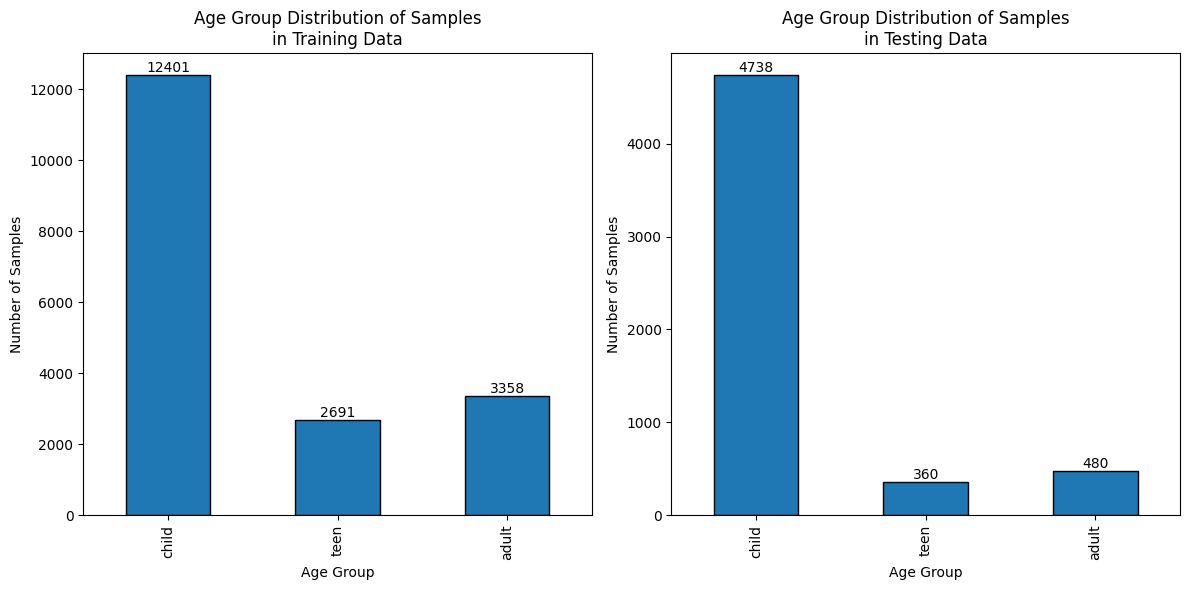

Child Sample Split: 72/28
 Teen Sample Split: 88/12
Adult Sample Split: 87/13
------------------------
   Average Split: 82/18


In [26]:
# globals
gesture = 'tap'
device_type = 'phone'
direction = None

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [27]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type)

else:
    print("Exported model found.")

Exported model found.


In [28]:
# define optimal model
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive

def get_tap_phone_best_model():

    # Average CV score on the training set was: 0.5289661957396079
    exported_pipeline = make_pipeline(
        SelectPercentile(score_func=f_classif, percentile=23),
        RobustScaler(),
        ZeroCount(),
        MLPClassifier(alpha=0.1, learning_rate_init=0.001)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

This optimal model, `get_tap_phone_best_model()` is a pipeline discovered by the Tree-based Pipeline Optimization Tool (TPOT)
It was trained using input samples grouped by user_id
The selected scoring method is macro F1 score and achieved an average accuracy of 84% with imbalanced guesses for only child and adult (no teen guesses)
Training ended after 100 generations after resolving an error that occurs when providing sample weights to TPOTClassifier()

In [29]:
# fit optimal model
model = get_tap_phone_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('selectpercentile', SelectPercentile(percentile=23)),
                ('robustscaler', RobustScaler()), ('zerocount', ZeroCount()),
                ('mlpclassifier', MLPClassifier(alpha=0.1, random_state=42))])

In [30]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.842954463965579


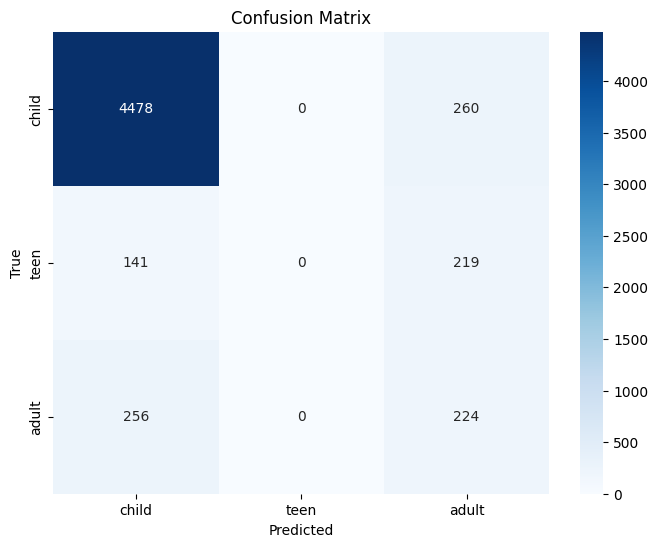

Classification Report
              precision    recall  f1-score   support

       adult       0.32      0.47      0.38       480
       child       0.92      0.95      0.93      4738
        teen       0.00      0.00      0.00       360

    accuracy                           0.84      5578
   macro avg       0.41      0.47      0.44      5578
weighted avg       0.81      0.84      0.82      5578



/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [31]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [32]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

### Tablet

Getting tap features dataframe...
Loaded tap_features_df from Checkpoints/tap_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


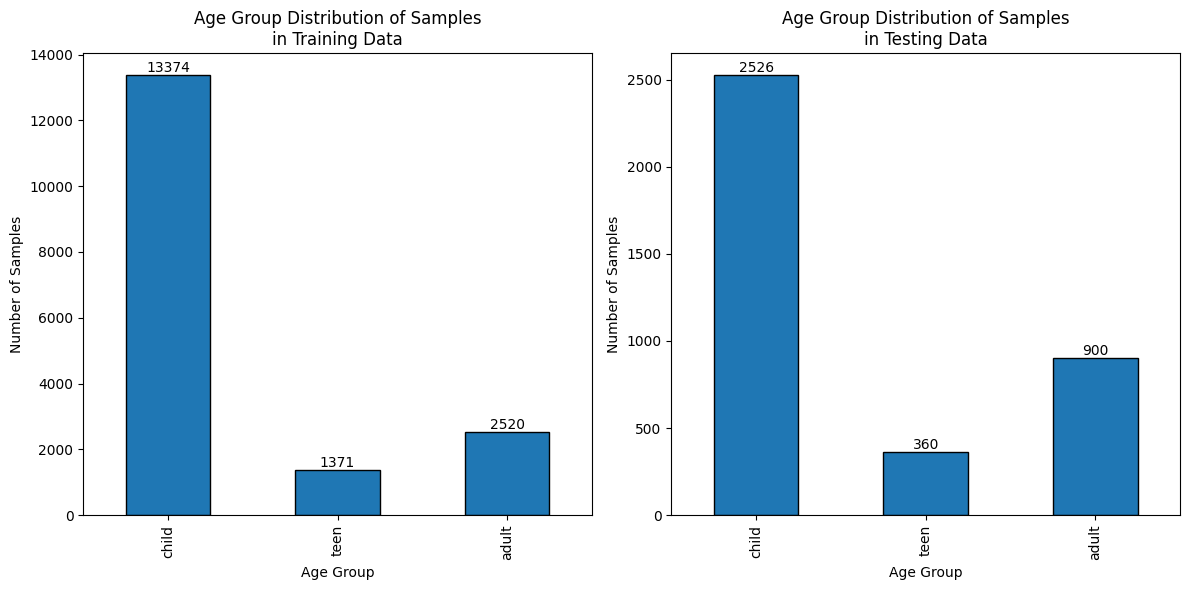

Child Sample Split: 84/16
 Teen Sample Split: 79/21
Adult Sample Split: 74/26
------------------------
   Average Split: 79/21


In [33]:
# globals
gesture = 'tap'
device_type = 'tablet'
direction = None

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [34]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type)

else:
    print("Exported model found.")

Exported model found.


In [35]:
# define optimal model (from TPOT export)
from sklearn.feature_selection import SelectFwe, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

def get_tap_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.7674201152370437
    exported_pipeline = make_pipeline(
        make_union(
            make_pipeline(
                ZeroCount(),
                SelectFwe(score_func=f_classif, alpha=0.04)
            ),
            FunctionTransformer(copy)
        ),
        MLPClassifier(alpha=0.1, learning_rate_init=0.001)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [36]:
# define optimal model (from TPOT export)
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive

def get_tap_tablet_best_model():

    # Average CV score on the training set was: 0.6706390167060482
    exported_pipeline = make_pipeline(
        VarianceThreshold(threshold=0.001),
        StandardScaler(),
        SGDClassifier(alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=1.0, learning_rate="constant", loss="hinge", penalty="elasticnet", power_t=0.1)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [37]:
# fit optimal model
model = get_tap_tablet_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.001)),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, eta0=0.01, fit_intercept=False,
                               l1_ratio=1.0, learning_rate='constant',
                               penalty='elasticnet', power_t=0.1,
                               random_state=42))])

In [38]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.4548335974643423


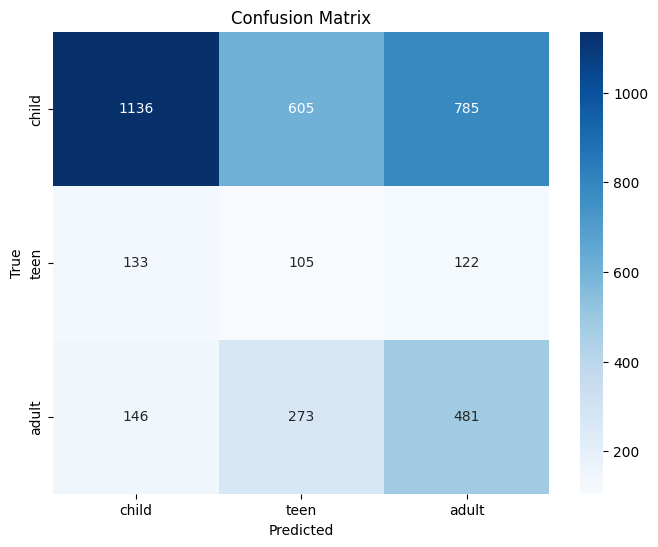

Classification Report
              precision    recall  f1-score   support

       adult       0.35      0.53      0.42       900
       child       0.80      0.45      0.58      2526
        teen       0.11      0.29      0.16       360

    accuracy                           0.45      3786
   macro avg       0.42      0.43      0.38      3786
weighted avg       0.63      0.45      0.50      3786



In [39]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [40]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

## Zoom

### Phone

#### Zoom-In

Getting zoom features dataframe...
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


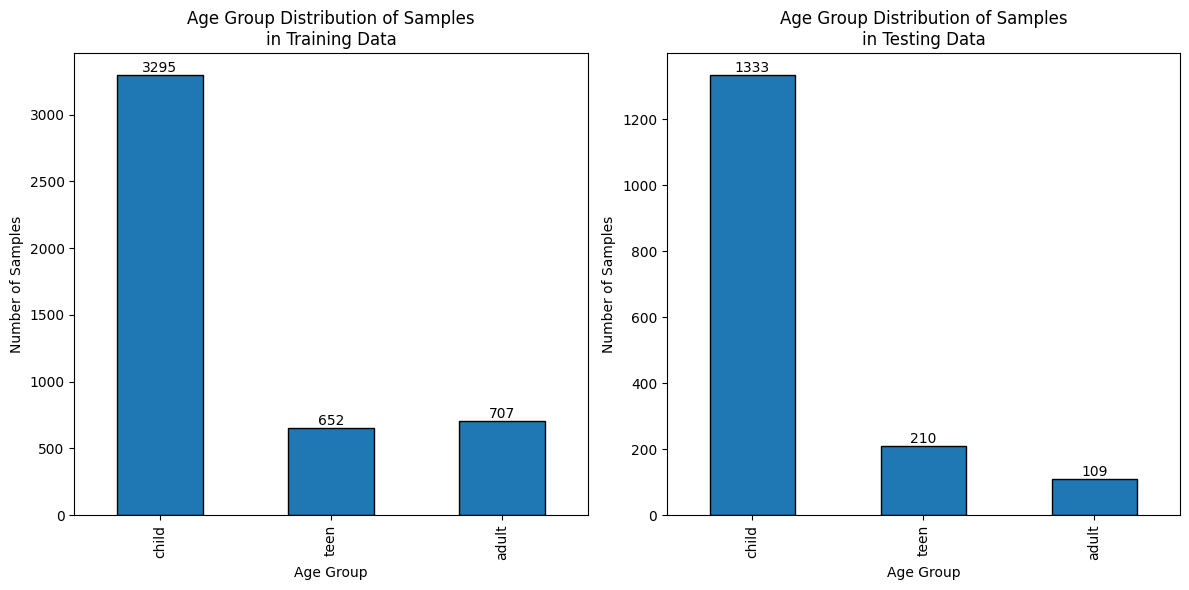

Child Sample Split: 71/29
 Teen Sample Split: 76/24
Adult Sample Split: 87/13
------------------------
   Average Split: 78/22


In [41]:
# globals
gesture = 'zoom'
device_type = 'phone'
direction = 'zoom-in'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [42]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [43]:
# define optimal model
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from tpot.export_utils import set_param_recursive

def get_zoom_in_phone_best_model_f1_weighted():

    # Average CV score on the training set was: 0.8620064442212225
    exported_pipeline = make_pipeline(
        MaxAbsScaler(),
        SGDClassifier(
            alpha=0.01,
            eta0=1.0,
            fit_intercept=False,
            l1_ratio=1.0,
            learning_rate="constant",
            loss="modified_huber",
            penalty="elasticnet",
            power_t=0.5
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [44]:
# define optimal model
from sklearn.linear_model import SGDClassifier

def get_zoom_in_phone_best_model():

    # Average CV score on the training set was: 0.6212860013655245
    exported_pipeline = SGDClassifier(
        alpha=0.001,
        eta0=0.1,
        fit_intercept=True,
        l1_ratio=0.25,
        learning_rate="constant",
        loss="squared_hinge",
        penalty="elasticnet",
        power_t=100.0
    )
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', 42)

    return exported_pipeline

In [45]:
# fit optimal model
model = get_zoom_in_phone_best_model()
model.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=0.1, l1_ratio=0.25, learning_rate='constant',
              loss='squared_hinge', penalty='elasticnet', power_t=100.0,
              random_state=42)

In [46]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.7838983050847458


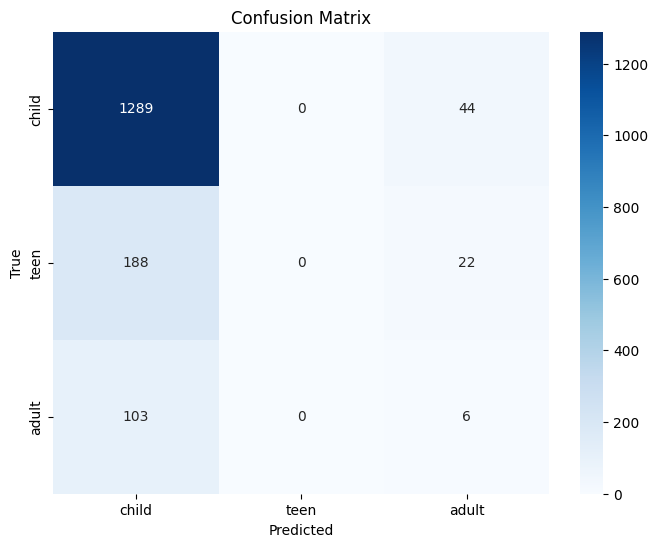

Classification Report
              precision    recall  f1-score   support

       adult       0.08      0.06      0.07       109
       child       0.82      0.97      0.88      1333
        teen       0.00      0.00      0.00       210

    accuracy                           0.78      1652
   macro avg       0.30      0.34      0.32      1652
weighted avg       0.66      0.78      0.72      1652



/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [47]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [48]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Zoom-Out

Getting zoom features dataframe...
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


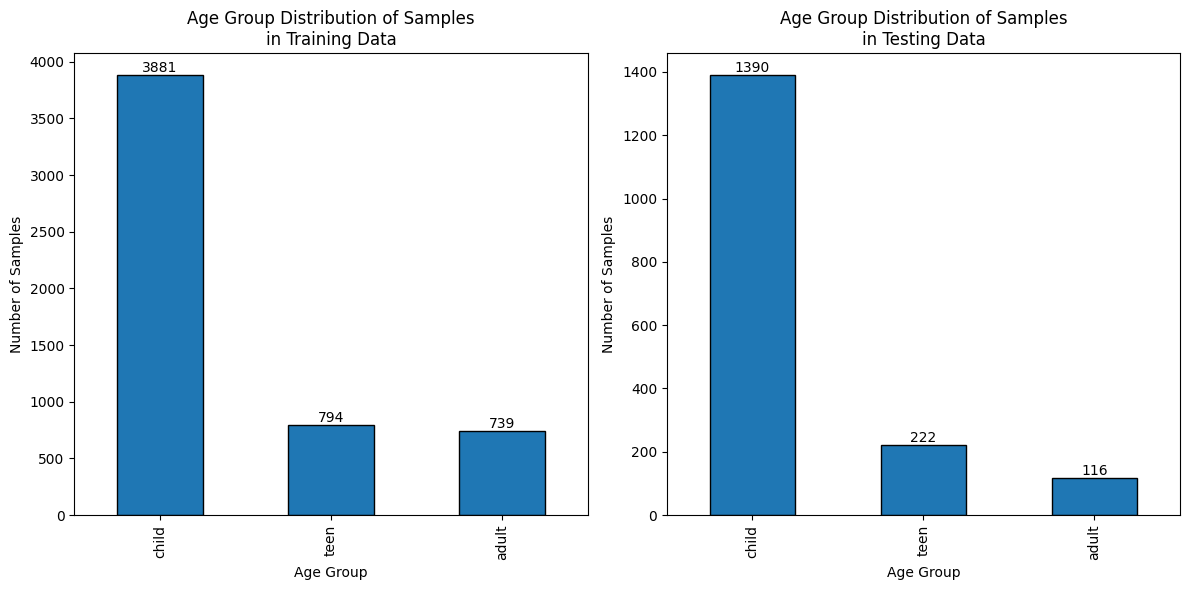

Child Sample Split: 74/26
 Teen Sample Split: 78/22
Adult Sample Split: 86/14
------------------------
   Average Split: 79/21


In [49]:
# globals
gesture = 'zoom'
device_type = 'phone'
direction = 'zoom-out'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [50]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [51]:
# define optimal model
from sklearn.linear_model import SGDClassifier

def get_zoom_out_phone_best_model_f1_weighted():

    # Average CV score on the training set was: 0.9099837803261337
    exported_pipeline = SGDClassifier(
        alpha=0.001,
        eta0=0.01,
        fit_intercept=False,
        l1_ratio=0.0,
        learning_rate="invscaling",
        loss="hinge",
        penalty="elasticnet",
        power_t=0.0
    )
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', 42)

    return exported_pipeline

In [52]:
# define optimal model
from sklearn.linear_model import SGDClassifier

def get_zoom_out_phone_best_model():

    # Average CV score on the training set was: 0.5976135115260606
    exported_pipeline = SGDClassifier(
        alpha=0.001,
        eta0=0.01,
        fit_intercept=False,
        l1_ratio=0.0, 
        learning_rate="constant",
        loss="hinge",
        penalty="elasticnet",
        power_t=0.5
    )
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', 42)

    return exported_pipeline

In [53]:
# fit optimal model
model = get_zoom_out_phone_best_model()
model.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=0.0,
              learning_rate='constant', penalty='elasticnet', random_state=42)

In [54]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.7326388888888888


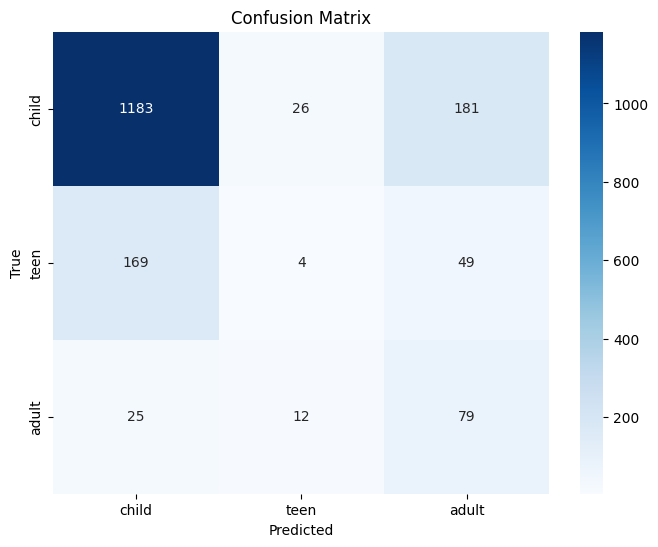

Classification Report
              precision    recall  f1-score   support

       adult       0.26      0.68      0.37       116
       child       0.86      0.85      0.86      1390
        teen       0.10      0.02      0.03       222

    accuracy                           0.73      1728
   macro avg       0.40      0.52      0.42      1728
weighted avg       0.72      0.73      0.72      1728



In [55]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [56]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

### Tablet

#### Zoom-In

Getting zoom features dataframe...
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


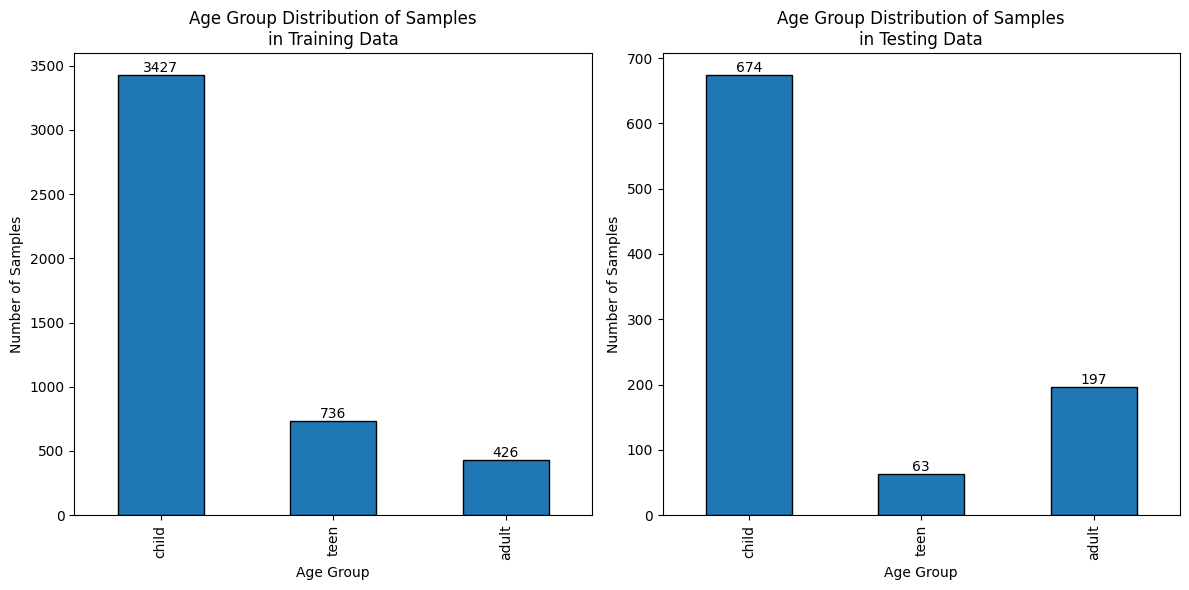

Child Sample Split: 84/16
 Teen Sample Split: 92/8
Adult Sample Split: 68/32
------------------------
   Average Split: 81/19


In [57]:
# globals
gesture = 'zoom'
device_type = 'tablet'
direction = 'zoom-in'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [58]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [59]:
# define optimal model
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tpot.export_utils import set_param_recursive


def get_zoom_in_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.8304841137632715
    exported_pipeline = make_pipeline(
        MinMaxScaler(),
        RFE(
            estimator=ExtraTreesClassifier(
                criterion="gini",
                max_features=0.9500000000000001,
                n_estimators=100
            ),
            step=0.9000000000000001
        ),
        FastICA(tol=0.5),
        StandardScaler(),
        MLPClassifier(alpha=0.01, learning_rate_init=0.01)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [60]:
# define optimal model
from sklearn.decomposition import FastICA
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive


def get_zoom_in_tablet_best_model():

    # Average CV score on the training set was: 0.5718205866673142
    exported_pipeline = make_pipeline(
        MinMaxScaler(),
        FastICA(tol=0.9500000000000001),
        ZeroCount(),
        MLPClassifier(alpha=0.001, learning_rate_init=0.01)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [61]:
# fit optimal model
model = get_zoom_in_tablet_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('fastica', FastICA(random_state=42, tol=0.9500000000000001)),
                ('zerocount', ZeroCount()),
                ('mlpclassifier',
                 MLPClassifier(alpha=0.001, learning_rate_init=0.01,
                               random_state=42))])

In [62]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.6777301927194861


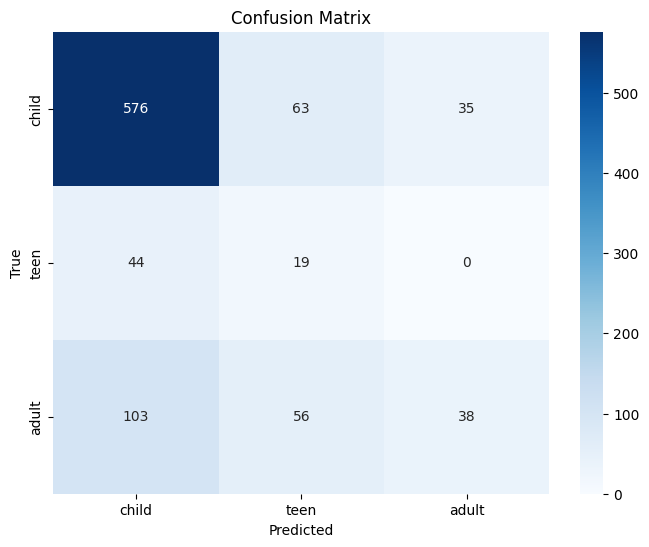

Classification Report
              precision    recall  f1-score   support

       adult       0.52      0.19      0.28       197
       child       0.80      0.85      0.82       674
        teen       0.14      0.30      0.19        63

    accuracy                           0.68       934
   macro avg       0.48      0.45      0.43       934
weighted avg       0.69      0.68      0.67       934



In [63]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [64]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Zoom-Out

Getting zoom features dataframe...
Loaded zoom_features_df from Checkpoints/zoom_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


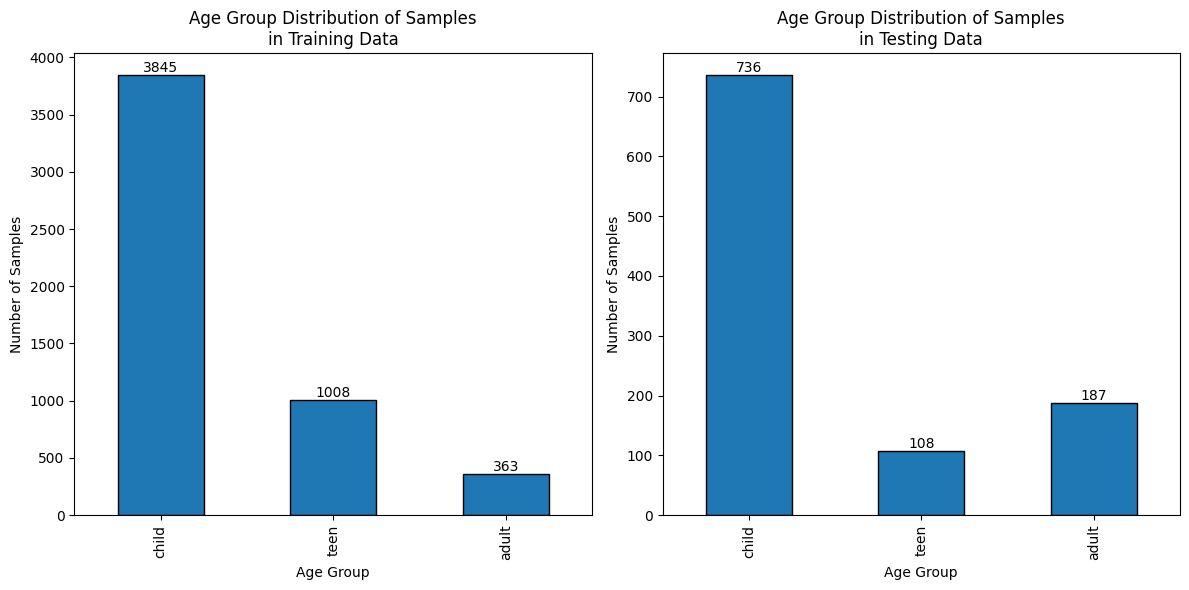

Child Sample Split: 84/16
 Teen Sample Split: 90/10
Adult Sample Split: 66/34
------------------------
   Average Split: 80/20


In [65]:
# globals
gesture = 'zoom'
device_type = 'tablet'
direction = 'zoom-out'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [66]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [67]:
# define optimal model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from tpot.export_utils import set_param_recursive


def get_zoom_out_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.8328819025830071
    exported_pipeline = make_pipeline(
        StandardScaler(),
        MaxAbsScaler(),
        RFE(
            estimator=ExtraTreesClassifier(
                criterion="gini",
                max_features=0.15000000000000002,
                n_estimators=100
            ),
            step=0.4
        ),
        MLPClassifier(alpha=0.01, learning_rate_init=0.001)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [68]:
# define optimal model
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive


def get_zoom_out_tablet_best_model():

    # Average CV score on the training set was: 0.5154457915481714
    exported_pipeline = make_pipeline(
        StandardScaler(),
        SelectPercentile(score_func=f_classif, percentile=58),
        MLPClassifier(alpha=0.0001, learning_rate_init=0.01)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [69]:
# fit optimal model
model = get_zoom_out_tablet_best_model()
model.fit(X_train, y_train)

/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [36 37 42 43 44 45 48 49 56 57] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectpercentile', SelectPercentile(percentile=58)),
                ('mlpclassifier',
                 MLPClassifier(learning_rate_init=0.01, random_state=42))])

In [70]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.6964112512124151


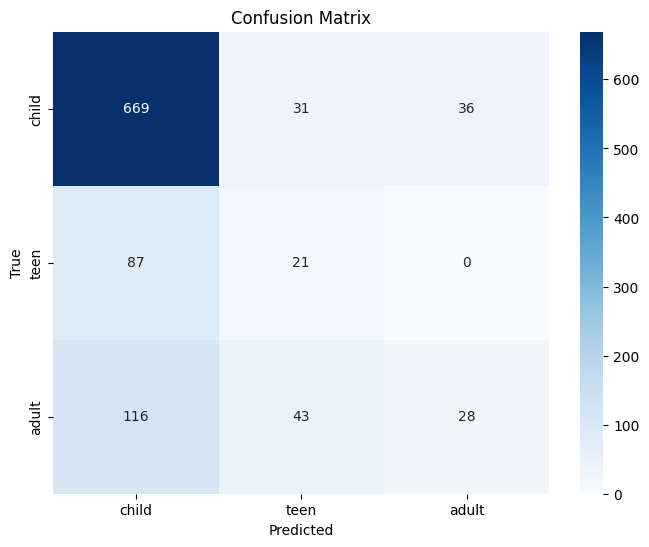

Classification Report
              precision    recall  f1-score   support

       adult       0.44      0.15      0.22       187
       child       0.77      0.91      0.83       736
        teen       0.22      0.19      0.21       108

    accuracy                           0.70      1031
   macro avg       0.48      0.42      0.42      1031
weighted avg       0.65      0.70      0.66      1031



In [71]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [72]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

## Swipe

### Phone

#### Swipe-Up

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


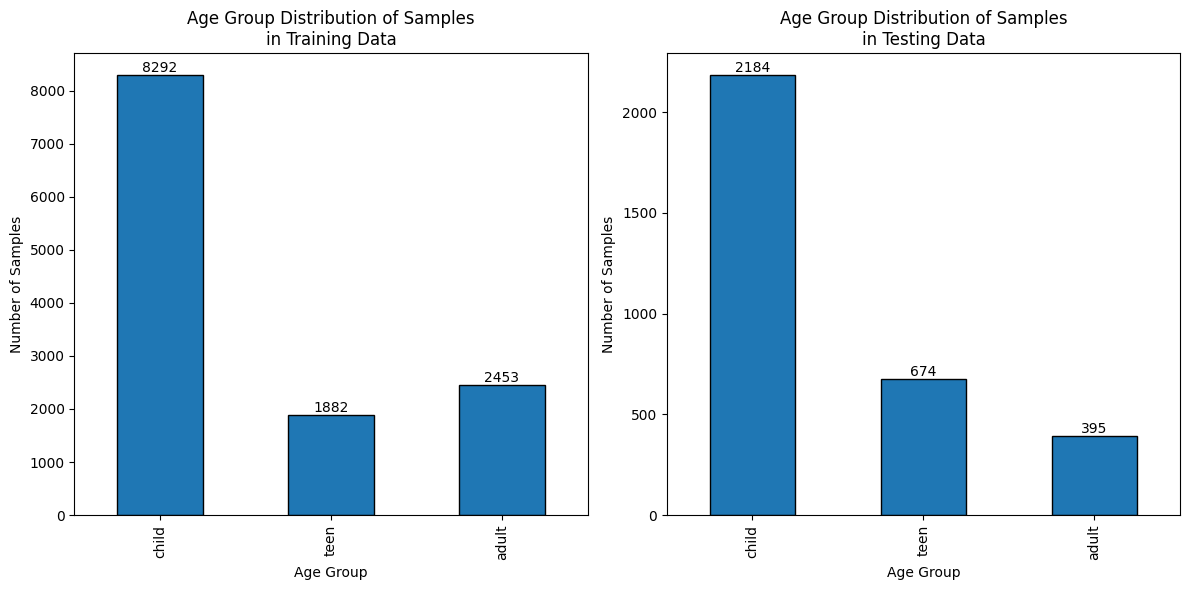

Child Sample Split: 79/21
 Teen Sample Split: 74/26
Adult Sample Split: 86/14
------------------------
   Average Split: 80/20


In [73]:
# globals
gesture = 'swipe'
device_type = 'phone'
direction = 'swipe-up'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [74]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [75]:
# define optimal model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from tpot.export_utils import set_param_recursive


def get_swipe_up_phone_best_model_f1_weighted():

    # Average CV score on the training set was: 0.7512237035406689
    exported_pipeline = make_pipeline(
        RobustScaler(),
        RandomForestClassifier(
            bootstrap=True,
            criterion="gini",
            max_features=0.8500000000000001,
            min_samples_leaf=17,
            min_samples_split=12,
            n_estimators=100
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [76]:
# define optimal model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive


def get_swipe_up_phone_best_model():

    # Average CV score on the training set was: 0.5311752821143861
    exported_pipeline = make_pipeline(
        RobustScaler(),
        MaxAbsScaler(),
        ZeroCount(),
        ZeroCount(),
        RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.8,
                               min_samples_leaf=20, min_samples_split=18, n_estimators=100)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [77]:
# fit optimal model
model = get_swipe_up_phone_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('maxabsscaler', MaxAbsScaler()), ('zerocount-1', ZeroCount()),
                ('zerocount-2', ZeroCount()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_features=0.8,
                                        min_samples_leaf=20,
                                        min_samples_split=18,
                                        random_state=42))])

In [78]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.687058100215186


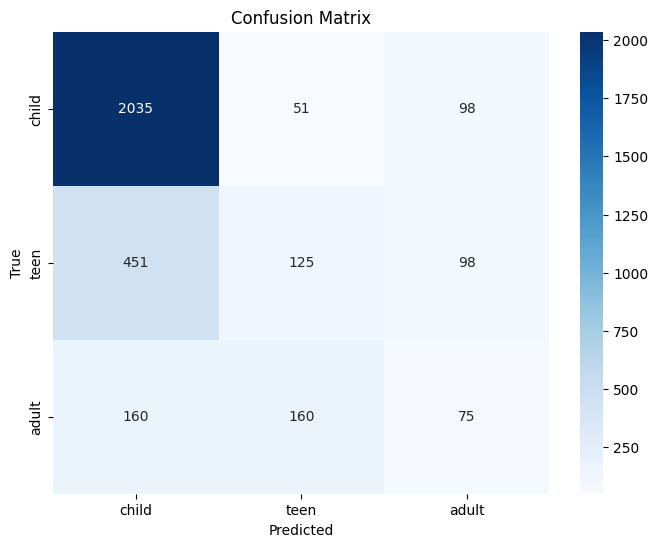

Classification Report
              precision    recall  f1-score   support

       adult       0.28      0.19      0.23       395
       child       0.77      0.93      0.84      2184
        teen       0.37      0.19      0.25       674

    accuracy                           0.69      3253
   macro avg       0.47      0.44      0.44      3253
weighted avg       0.63      0.69      0.64      3253



In [79]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [80]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Swipe-Down

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


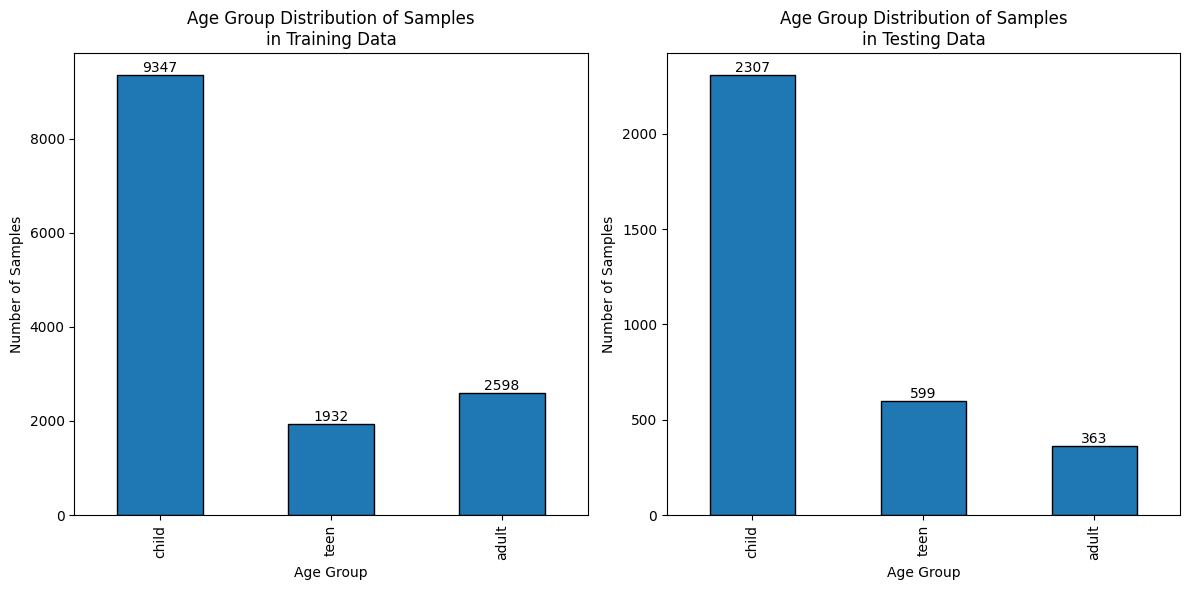

Child Sample Split: 80/20
 Teen Sample Split: 76/24
Adult Sample Split: 88/12
------------------------
   Average Split: 81/19


In [81]:
# globals
gesture = 'swipe'
device_type = 'phone'
direction = 'swipe-down'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [82]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [83]:
# define optimal model
from sklearn.linear_model import SGDClassifier


def get_swipe_down_phone_best_model():

    # Average CV score on the training set was: 0.7119592629576972
    exported_pipeline = SGDClassifier(
        alpha=0.001,
        eta0=1.0,
        fit_intercept=False,
        l1_ratio=0.5,
        learning_rate="invscaling",
        loss="modified_huber",
        penalty="elasticnet",
        power_t=0.0
    )
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', 42)

    return exported_pipeline

In [84]:
# fit optimal model
model = get_swipe_down_phone_best_model()
model.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5,
              learning_rate='invscaling', loss='modified_huber',
              penalty='elasticnet', power_t=0.0, random_state=42)

In [85]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.7014377485469563


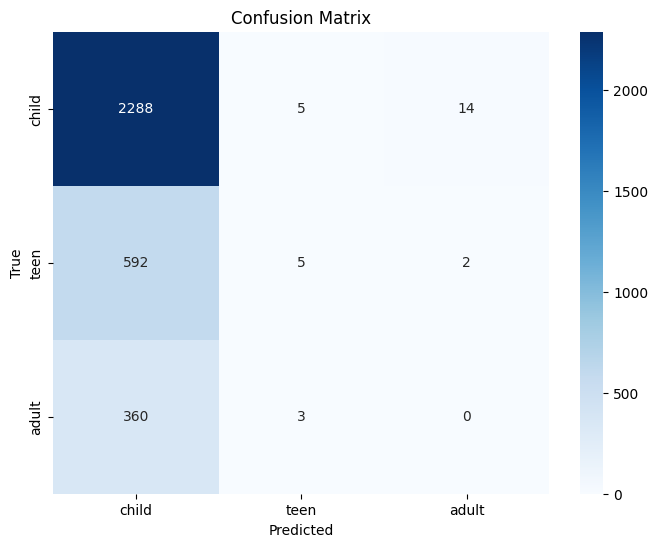

Classification Report
              precision    recall  f1-score   support

       adult       0.00      0.00      0.00       363
       child       0.71      0.99      0.82      2307
        teen       0.38      0.01      0.02       599

    accuracy                           0.70      3269
   macro avg       0.36      0.33      0.28      3269
weighted avg       0.57      0.70      0.59      3269



In [86]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [87]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Swipe-Left

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


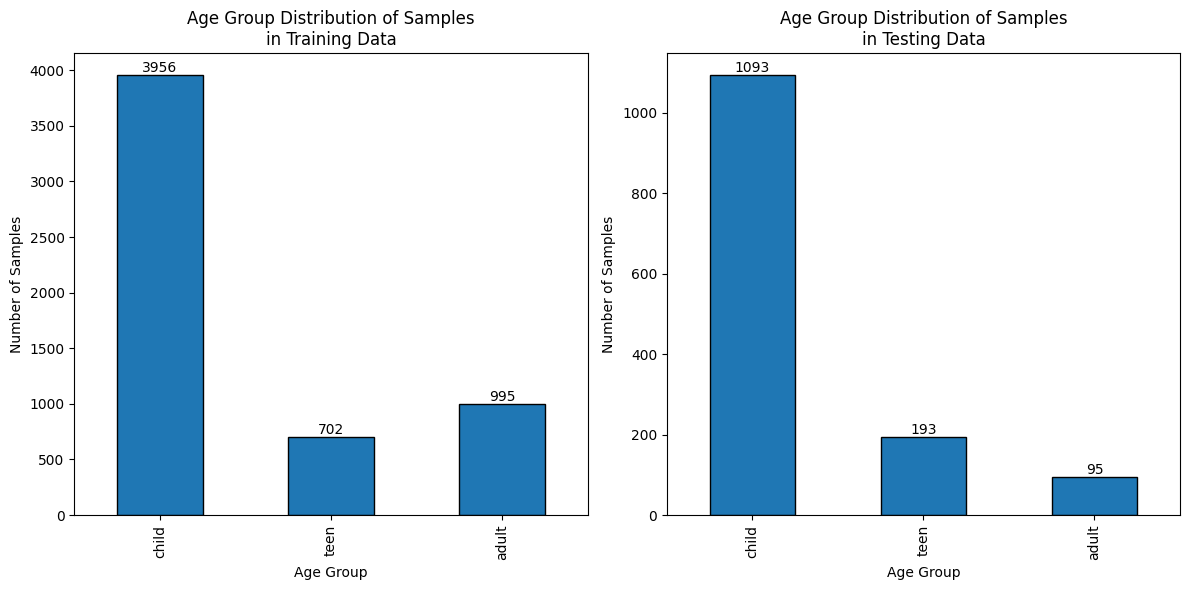

Child Sample Split: 78/22
 Teen Sample Split: 78/22
Adult Sample Split: 91/9
------------------------
   Average Split: 82/18


In [88]:
# globals
gesture = 'swipe'
device_type = 'phone'
direction = 'swipe-left'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [89]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [90]:
# define optimal model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive


def get_swipe_left_phone_best_model_f1_weighted():

    # Average CV score on the training set was: 0.80747694897343
    exported_pipeline = make_pipeline(
        RFE(
            estimator=ExtraTreesClassifier(
                criterion="gini",
                max_features=0.6500000000000001,
                n_estimators=100
            ),
            step=0.6000000000000001
        ),
        ExtraTreesClassifier(
            bootstrap=True,
            criterion="entropy",
            max_features=0.6500000000000001,
            min_samples_leaf=10,
            min_samples_split=4,
            n_estimators=100
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [91]:
# define optimal model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.svm import LinearSVC
from tpot.export_utils import set_param_recursive


def get_swipe_left_phone_best_model():

    # Average CV score on the training set was: 0.639027759317193
    exported_pipeline = make_pipeline(
        Binarizer(threshold=0.2),
        LinearSVC(C=0.1, dual=True, loss="hinge", penalty="l2", tol=0.001)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [92]:
# fit optimal model
model = get_swipe_left_phone_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('binarizer', Binarizer(threshold=0.2)),
                ('linearsvc',
                 LinearSVC(C=0.1, dual=True, loss='hinge', random_state=42,
                           tol=0.001))])

In [93]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.7617668356263577


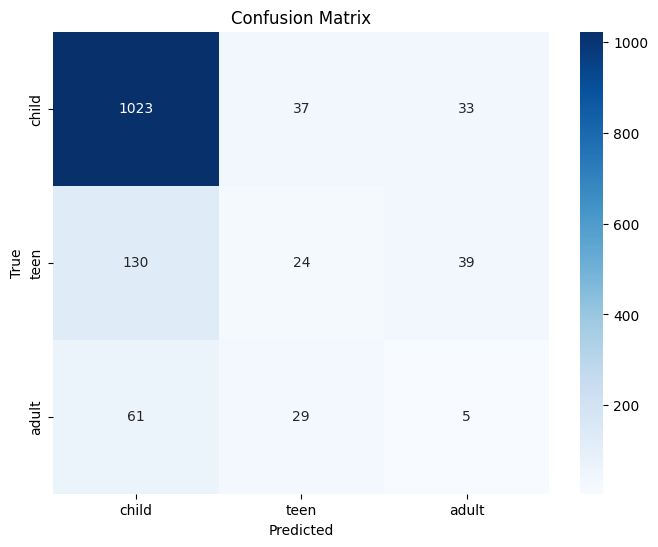

Classification Report
              precision    recall  f1-score   support

       adult       0.06      0.05      0.06        95
       child       0.84      0.94      0.89      1093
        teen       0.27      0.12      0.17       193

    accuracy                           0.76      1381
   macro avg       0.39      0.37      0.37      1381
weighted avg       0.71      0.76      0.73      1381



In [94]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [95]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Swipe-Right

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


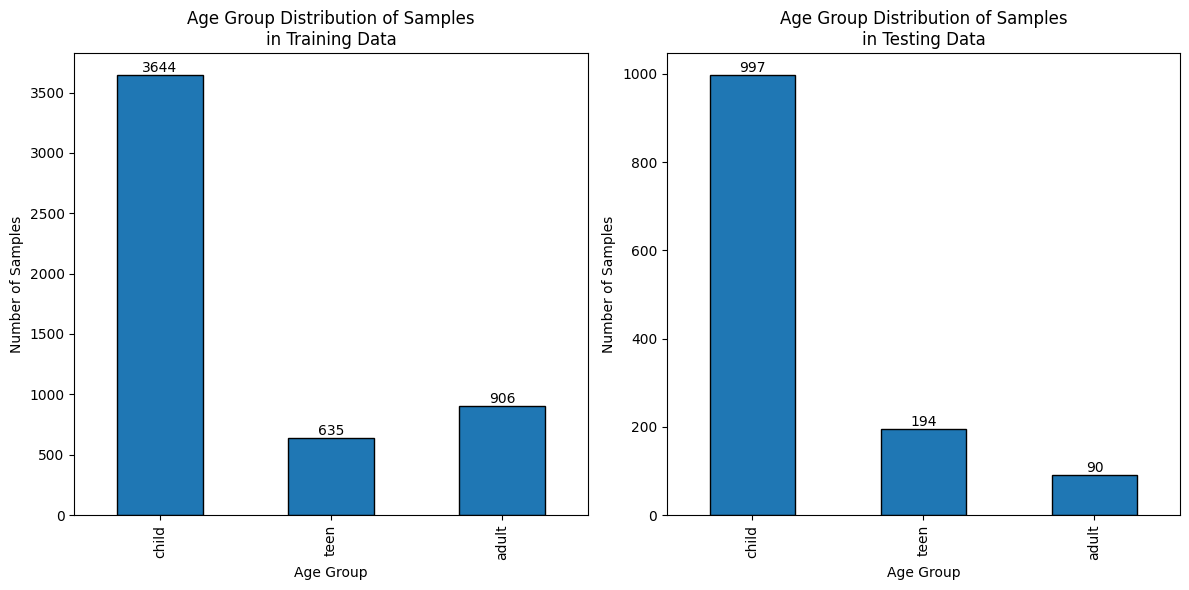

Child Sample Split: 79/21
 Teen Sample Split: 77/23
Adult Sample Split: 91/9
------------------------
   Average Split: 82/18


In [96]:
# globals
gesture = 'swipe'
device_type = 'phone'
direction = 'swipe-right'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [97]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [98]:
# define optimal model
from sklearn.ensemble import GradientBoostingClassifier


def get_swipe_right_phone_best_modelf1_weighted():

    # Average CV score on the training set was: 0.827952604459662
    exported_pipeline = GradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=1,
        max_features=0.15000000000000002,
        min_samples_leaf=15,
        min_samples_split=4,
        n_estimators=100,
        subsample=0.4
    )
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', 42)

    return exported_pipeline

In [99]:
# define optimal model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from tpot.export_utils import set_param_recursive


def get_swipe_right_phone_best_model():

    # Average CV score on the training set was: 0.49414250024413603
    exported_pipeline = make_pipeline(
        MaxAbsScaler(),
        GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=0.05,
                                   min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=0.45)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [100]:
# fit optimal model
model = get_swipe_right_phone_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=2,
                                            max_features=0.05,
                                            min_samples_leaf=5, random_state=42,
                                            subsample=0.45))])

In [101]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.7392661982825918


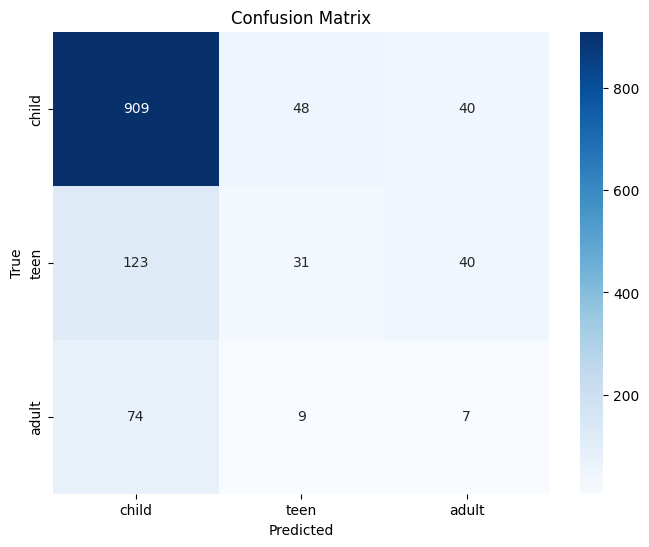

Classification Report
              precision    recall  f1-score   support

       adult       0.08      0.08      0.08        90
       child       0.82      0.91      0.86       997
        teen       0.35      0.16      0.22       194

    accuracy                           0.74      1281
   macro avg       0.42      0.38      0.39      1281
weighted avg       0.70      0.74      0.71      1281



In [102]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [103]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

### Tablet

#### Swipe-Up

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


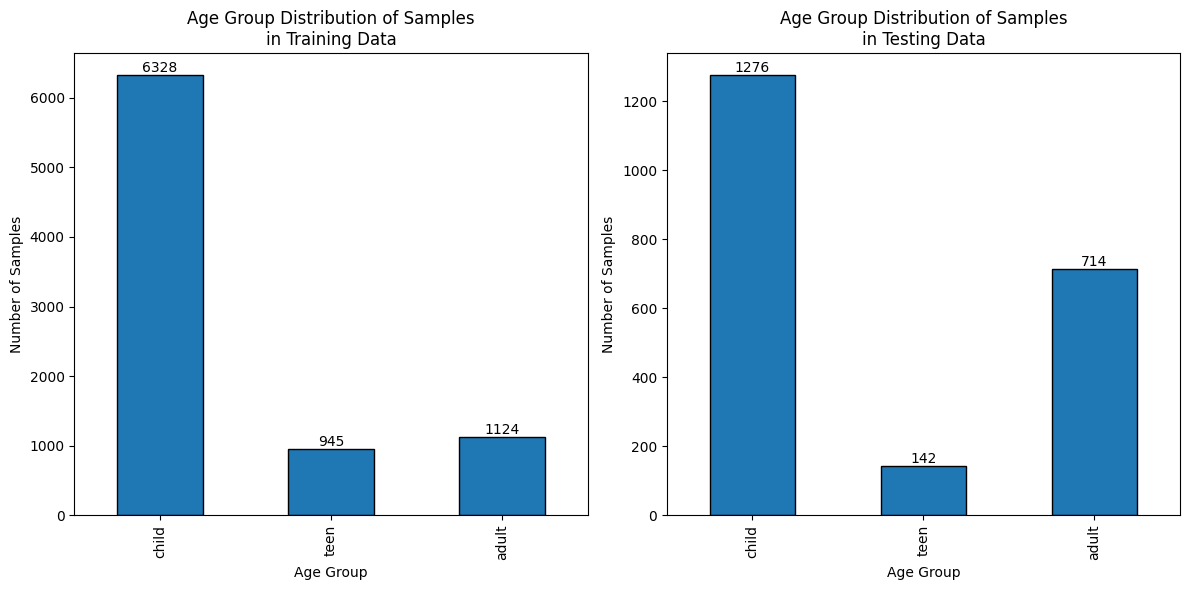

Child Sample Split: 83/17
 Teen Sample Split: 87/13
Adult Sample Split: 61/39
------------------------
   Average Split: 77/23


In [104]:
# globals
gesture = 'swipe'
device_type = 'tablet'
direction = 'swipe-up'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [105]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [106]:
# define optimal model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from tpot.export_utils import set_param_recursive


def get_swipe_up_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.7582855323691322
    exported_pipeline = make_pipeline(
        MinMaxScaler(),
        GradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=3,
            max_features=0.9000000000000001,
            min_samples_leaf=15,
            min_samples_split=3,
            n_estimators=100,
            subsample=0.05
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [107]:
# define optimal model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive


def get_swipe_up_tablet_best_model():

    # Average CV score on the training set was: 0.5115469862579808
    exported_pipeline = make_pipeline(
        MinMaxScaler(),
        ZeroCount(),
        DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=5, min_samples_split=3)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [108]:
# fit optimal model
model = get_swipe_up_tablet_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('zerocount', ZeroCount()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=5, min_samples_split=3,
                                        random_state=42))])

In [109]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.5558161350844277


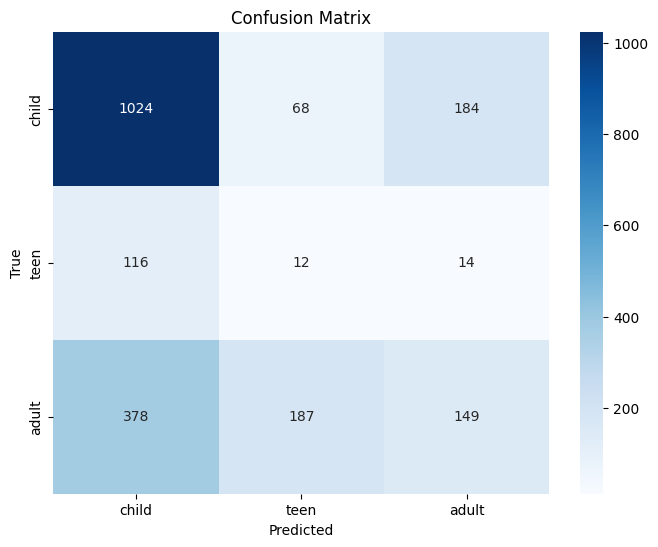

Classification Report
              precision    recall  f1-score   support

       adult       0.43      0.21      0.28       714
       child       0.67      0.80      0.73      1276
        teen       0.04      0.08      0.06       142

    accuracy                           0.56      2132
   macro avg       0.38      0.37      0.36      2132
weighted avg       0.55      0.56      0.54      2132



In [110]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [111]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Swipe-Down

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


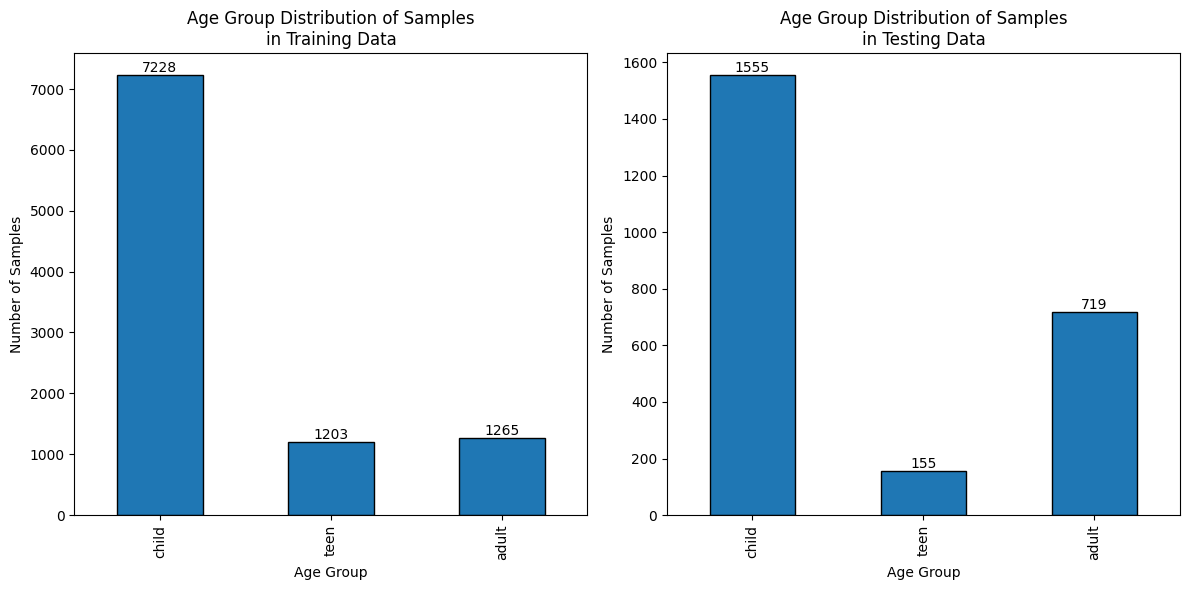

Child Sample Split: 82/18
 Teen Sample Split: 89/11
Adult Sample Split: 64/36
------------------------
   Average Split: 78/22


In [112]:
# globals
gesture = 'swipe'
device_type = 'tablet'
direction = 'swipe-down'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [113]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [114]:
# define optimal model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive


def get_swipe_down_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.734812466173996
    exported_pipeline = make_pipeline(
        SelectPercentile(
            score_func=f_classif,
            percentile=79
        ),
        GradientBoostingClassifier(
            learning_rate=0.5,
            max_depth=6,
            max_features=0.8,
            min_samples_leaf=8,
            min_samples_split=4,
            n_estimators=100,
            subsample=0.5
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [115]:
# define optimal model
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive


def get_swipe_down_tablet_best_model():

    # Average CV score on the training set was: 0.5059124041231958
    exported_pipeline = make_pipeline(
        StandardScaler(),
        MLPClassifier(alpha=0.01, learning_rate_init=0.01)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [116]:
# fit optimal model
model = get_swipe_down_tablet_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(alpha=0.01, learning_rate_init=0.01,
                               random_state=42))])

In [117]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.6117743927542199


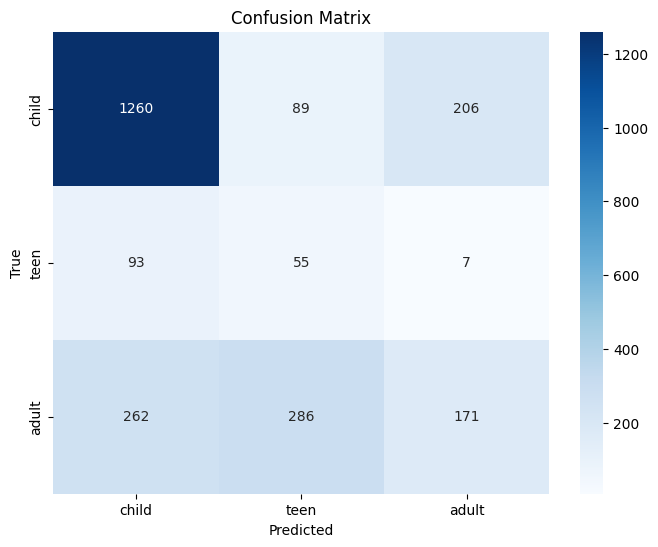

Classification Report
              precision    recall  f1-score   support

       adult       0.45      0.24      0.31       719
       child       0.78      0.81      0.79      1555
        teen       0.13      0.35      0.19       155

    accuracy                           0.61      2429
   macro avg       0.45      0.47      0.43      2429
weighted avg       0.64      0.61      0.61      2429



In [118]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [119]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Swipe-Left

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


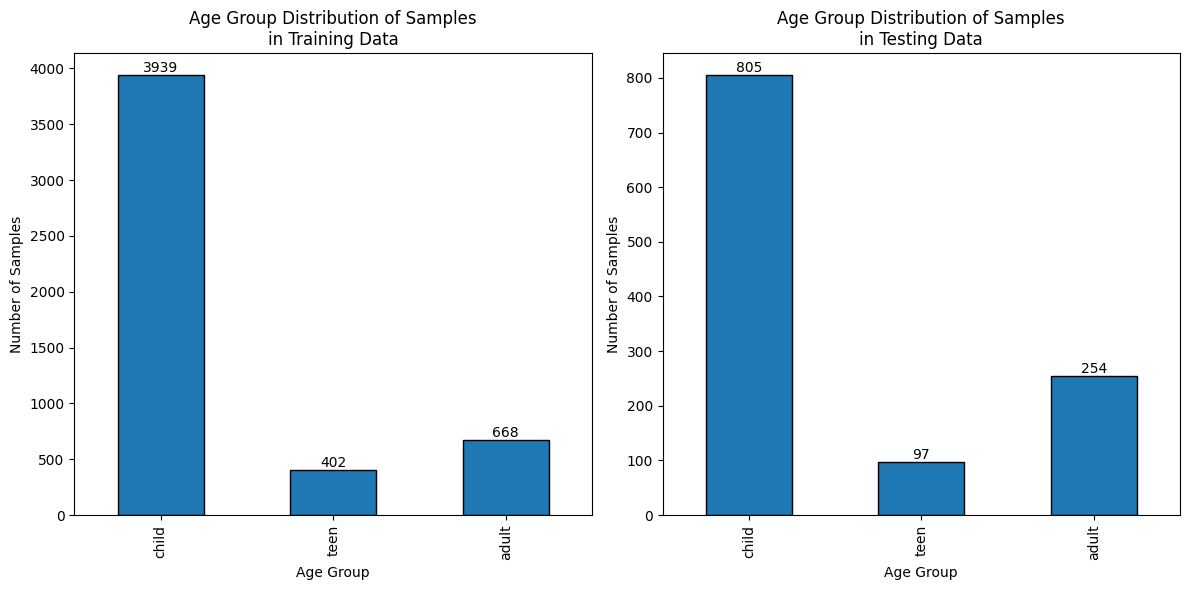

Child Sample Split: 83/17
 Teen Sample Split: 81/19
Adult Sample Split: 72/28
------------------------
   Average Split: 79/21


In [120]:
# globals
gesture = 'swipe'
device_type = 'tablet'
direction = 'swipe-left'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [121]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [122]:
# define optimal model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive


def get_swipe_left_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.7806663705772975
    exported_pipeline = make_pipeline(
        ZeroCount(),
        StandardScaler(),
        MaxAbsScaler(),
        GradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=4,
            max_features=0.2,
            min_samples_leaf=5,
            min_samples_split=11,
            n_estimators=100,
            subsample=0.5
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [123]:
# define optimal model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive


def get_swipe_left_tablet_best_model():

    # Average CV score on the training set was: 0.5301799639825902
    exported_pipeline = make_pipeline(
        StandardScaler(),
        GradientBoostingClassifier(learning_rate=0.1, max_depth=4, max_features=0.5,
                                   min_samples_leaf=17, min_samples_split=12, n_estimators=100, subsample=0.4)
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [124]:
# fit optimal model
model = get_swipe_left_tablet_best_model()
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, max_features=0.5,
                                            min_samples_leaf=17,
                                            min_samples_split=12,
                                            random_state=42, subsample=0.4))])

In [125]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.6557093425605537


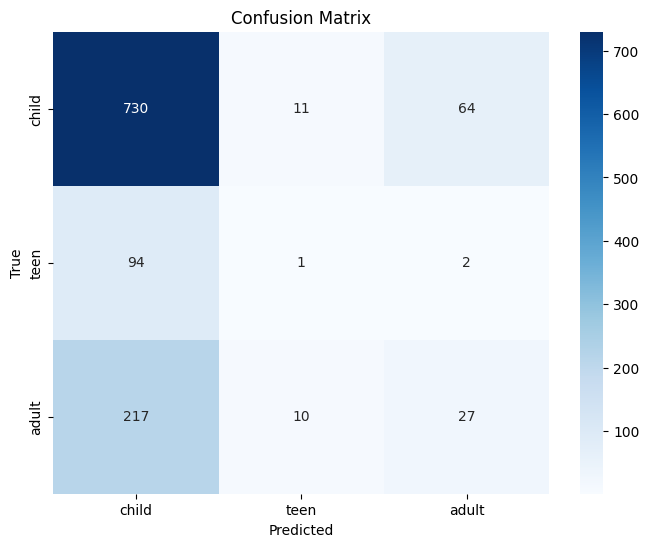

Classification Report
              precision    recall  f1-score   support

       adult       0.29      0.11      0.16       254
       child       0.70      0.91      0.79       805
        teen       0.05      0.01      0.02        97

    accuracy                           0.66      1156
   macro avg       0.35      0.34      0.32      1156
weighted avg       0.56      0.66      0.59      1156



In [126]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [127]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred

#### Swipe-Right

Getting swipe features dataframe...
Loaded swipe_features_df from Checkpoints/swipe_features_df.pkl
Verifying no users...
No user_id is present in both training and testing.


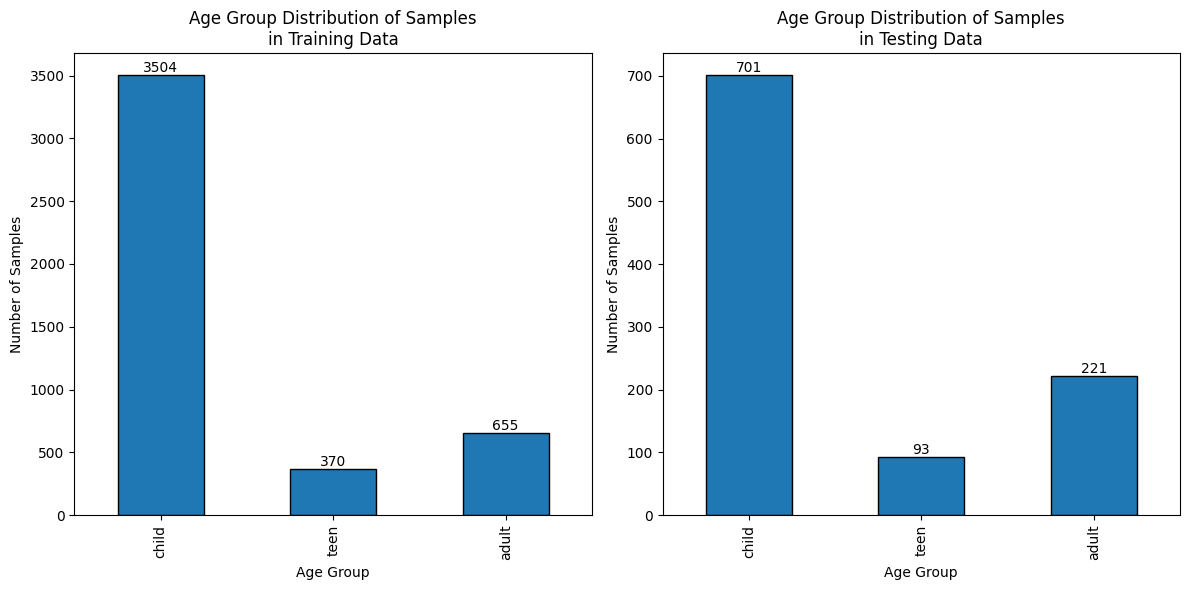

Child Sample Split: 83/17
 Teen Sample Split: 80/20
Adult Sample Split: 75/25
------------------------
   Average Split: 79/21


In [128]:
# globals
gesture = 'swipe'
device_type = 'tablet'
direction = 'swipe-right'

# get data
df = get_features_df(gesture, device_type, direction)

# split data
X_train, X_test, y_train, y_test, groups = train_test_split_on_users(df)
verify_users(X_train, X_test)
plot_train_test_sample_split(X_train, X_test)
report_train_test_sample_split(X_train, X_test)

# remove unnused columns
X_train = remove_columns(X_train)
X_test = remove_columns(X_test)

In [129]:
# check if the exported model exists before running TPOT
if not exported_model_exists(gesture, device_type, direction):
    print("Exported model not found. Running Tree-based Pipeline Optimization Tool (TPOT)...")

    # find optimal pipeline, model, and hyperparameters with training data
    model = find_best_model_with_tpot(X_train, y_train, groups)

    # export optimal model
    export_model(model, gesture, device_type, direction)

else:
    print("Exported model found.")

Exported model found.


In [130]:
# define optimal model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tpot.export_utils import set_param_recursive


def get_swipe_right_tablet_best_model_f1_weighted():

    # Average CV score on the training set was: 0.7279588435516136
    exported_pipeline = make_pipeline(
        StandardScaler(),
        RFE(
            estimator=ExtraTreesClassifier(
                criterion="gini",
                max_features=0.7000000000000001,
                n_estimators=100
            ),
            step=0.2
        ),
        MLPClassifier(
            alpha=0.1,
            learning_rate_init=0.001
        )
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [131]:
# define optimal model
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy


def get_swipe_right_tablet_best_model():

    # Average CV score on the training set was: 0.5454138065024169
    exported_pipeline = make_pipeline(
        make_union(
            FunctionTransformer(copy),
            make_pipeline(
                make_union(
                    FunctionTransformer(copy),
                    FunctionTransformer(copy)
                ),
                SelectPercentile(score_func=f_classif, percentile=17),
                PCA(iterated_power=2, svd_solver="randomized")
            )
        ),
        SelectPercentile(score_func=f_classif, percentile=17),
        GaussianNB()
    )
    # Fix random state for all the steps in exported pipeline
    set_param_recursive(exported_pipeline.steps, 'random_state', 42)

    return exported_pipeline

In [132]:
# fit optimal model
model = get_swipe_right_tablet_best_model()
model.fit(X_train, y_train)

/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [18 19 20 21 61 62 63 64] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [18 19 20 21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/tombirmingham/ChildSafetyProject/myenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer',
                                                 FunctionTransformer(func=<function copy at 0x1030164d0>)),
                                                ('pipeline',
                                                 Pipeline(steps=[('featureunion',
                                                                  FeatureUnion(transformer_list=[('functiontransformer-1',
                                                                                                  FunctionTransformer(func=<function copy at 0x1030164d0>)),
                                                                                                 ('functiontransformer-2',
                                                                                                  FunctionTransformer(func=<function copy at 0x1030164d0>))])),
                                                                 ('selectpercentile',
                                                                  SelectPercentile(percentile=17)),
                                                                 ('pca',
                                                                  PCA(iterated_power=2,
                                                                      random_state=42,
                                                                      svd_solver='randomized'))]))])),
                ('selectpercentile', SelectPercentile(percentile=17)),
                ('gaussiannb', GaussianNB())])

In [133]:
# generate predictions from test data
y_pred = model.predict(X_test)

Accuracy: 0.4896551724137931


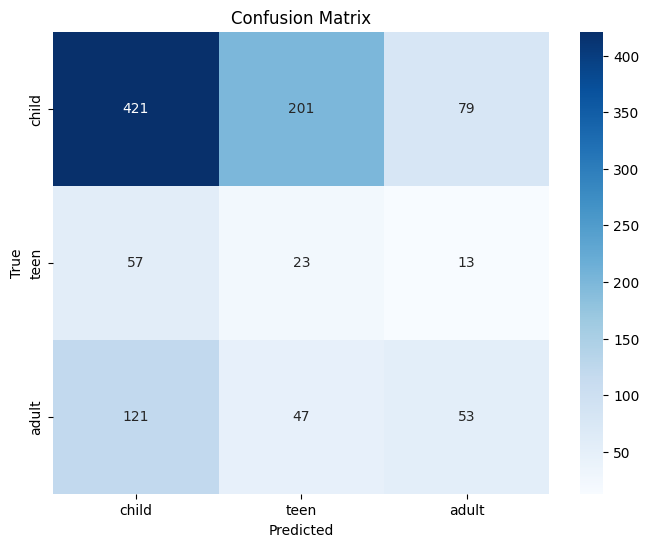

Classification Report
              precision    recall  f1-score   support

       adult       0.37      0.24      0.29       221
       child       0.70      0.60      0.65       701
        teen       0.08      0.25      0.13        93

    accuracy                           0.49      1015
   macro avg       0.38      0.36      0.35      1015
weighted avg       0.57      0.49      0.52      1015



In [134]:
# analyze optimal model
show_accuracy(y_test, y_pred)
show_confusion_matrix(y_test, y_pred)
show_classification_report(y_test, y_pred)

In [135]:
# Cleanup
del gesture, device_type, direction
del df
del X_train, X_test, y_train, y_test, groups
del model
del y_pred